The base for this work is from Dan Taranu's make_a360_plots.py , which can be found at:

https://github.com/lsst-sitcom/sciunit_galaxies/blob/tickets/DM-50124/bin.src/make_a360_plots.py 


In [1]:
from lsst.analysis.tools.atools.diffMatched import *
from lsst.analysis.tools.actions.vector import (
    CalcMomentSize,
    InjectedGalaxySelector,
    InjectedStarSelector,
)
from lsst.analysis.tools.atools import SizeMagnitudePlot
from lsst.analysis.tools.contexts import CoaddContext
from lsst.analysis.tools.interfaces import NoPlot
import lsst.daf.butler as dafButler
from lsst.geom import degrees, SpherePoint
import lsst.sphgeom as sphgeom
from lsst.utils.plotting import make_figure

from astropy.table import vstack
import healsparse as hsp
import matplotlib as mpl
import numpy as np
import skyproj

import astropy.units as u

import os
import math

from astropy.table import Table, join, vstack

import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from matplotlib import cm

import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

from scipy.stats import norm

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

In [2]:
def getBinsDegrees(binsmpc): 
    bindededegrees = []
    for binedge in binsmpc:
        # convert distances in Mpc to radians
        binradians = cosmo.mpc2rad(binedge, 0.22)
        # convert radians to deg 
        bindegrees = math.degrees(binradians)
        bindededegrees.append(bindegrees)

    return bindededegrees

# get the total area of the annului 
def getAreaFull(binsMpc):
    # cluster coordinates
    ra_bcg = 37.86501659859067
    dec_bcg = 6.982204815599694

    binsdegrees = getBinsDegrees(binsMpc)
    areasannulusarcmin = [] 
    for x in range(len(binsdegrees)-1): 
        # what is the area of the annulus (in sq deg) 
        areaannulus = np.pi* (binsdegrees[x+1]**2) - np.pi * (binsdegrees[x]**2)

        # convert to arcmin **2
        areaannulusarcmin = areaannulus * 3600
        
        areasannulusarcmin.append(areaannulusarcmin)
    return areasannulusarcmin, binsdegrees

def getDensityErrorPoissonCountOnly(binoccupancy, areas):
    areaarray = np.array(areas)
    # density = counts / area  
    # proportions is the success of the MC for the area estimation based on the mask - Binomial error (Will be small but include for completeness) 
    # counts is poisson error 
    uncertsquared = (np.sqrt(binoccupancy)/ areaarray)**2
    uncert = np.sqrt(uncertsquared)

    return uncert

def getBinomialStandardError(proportionsuccess, Nthrows): 
    variancesquared = (proportionsuccess*(1-proportionsuccess))/Nthrows
    variance = np.sqrt(variancesquared)
    return variance

def getDensityError(proportions, binoccupancy, areas, Nthrown):
    prop = np.array(proportions)
    areaarray = np.array(areas)
    # density = counts / area * proportion 
    # proportions is the success of the MC for the area estimation based on the mask - Binomial error (Will be small but include for completeness) 
    # counts is poisson error 
    uncertsquared = (np.sqrt(binoccupancy)/ areaarray)**2 + (binoccupancy/ (areaarray*prop))**2 * (prop*(1-prop))/Nthrown
    uncert = np.sqrt(uncertsquared)

    return uncert

def getDensityErrorJustPoisson(proportions, binoccupancy, areas, Nthrown):
    prop = np.array(proportions)
    areaarray = np.array(areas)
    # density = counts / area * proportion 
    # proportions is the success of the MC for the area estimation based on the mask - Binomial error (Will be small but include for completeness) 
    # counts is poisson error 
    uncertsquared = (np.sqrt(binoccupancy)/ areaarray)**2
    uncert = np.sqrt(uncertsquared)

    return uncert

def getUnmaskedArea(radiusIn, radiusOut, numberobjects, plot):
    # cluster coordinates
    ra_bcg = 37.86501659859067
    dec_bcg = 6.982204815599694

    circlemap = hsp.HealSparseMap.make_empty(32, 32768, np.uint16)

    # the outer radius 
    circlemap |= hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=radiusOut, value=1)
    # the inner radius 
    circlemap &= hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=radiusIn, value=0)

    ra_rand, dec_rand = hsp.make_uniform_randoms_fast(circlemap, numberobjects)

    #plt.scatter(ra_rand, dec_rand, marker='.', s=0.2)

    mask_rand = ~mask_hsp['full_mask'].get_values_pos(ra_rand, dec_rand, lonlat=True)

    if plot:
        plt.scatter(ra_rand, dec_rand, marker='.', s=0.2, color='c')
        plt.scatter(ra_rand[mask_rand], dec_rand[mask_rand], marker='.', s=0.2, color='black')

    numberTrue = np.sum(mask_rand)
    proportion = numberTrue/numberobjects

    # what is the area of the annulus (in sq deg) 
    areaannulus = np.pi* (radiusOut**2) - np.pi * (radiusIn**2)
    
    # corresponding amount of area left, given the mask
    effectivearea = areaannulus * proportion

    arearemoved = areaannulus - effectivearea

    # convert to arcmin **2
    areaannulusarcmin = areaannulus * 3600
    effectiveareaarcmin = areaannulusarcmin * proportion
    arearemovedarcmin = areaannulusarcmin - effectiveareaarcmin

    return effectiveareaarcmin, proportion

def removeZeroBins(listvalues):
    i = len(listvalues)
    while i > 0 and listvalues[i - 1] == 0:
        i -= 1
    return listvalues[:i]  

def computeWilsonCISingle(p, confidenceInterval, N):
    z = norm.ppf(1 - (1-confidenceInterval)/2)
    denom = 1 + z**2/N
    center = (p + (z**2/(2*N)))/ denom
    halfwidth = (z/ denom) * np.sqrt((p*(1-p))/N + z**2/(4*N**2))
    #upperamount = center + halfwidth
    #loweramount = center - halfwidth
    return halfwidth

def computeWilsonCIMany(proportions, confidenceInterval, N):
    errwidths = []
    for proportion in proportions: 
        width = computeWilsonCISingle(proportion, confidenceInterval, N)
        errwidths.append(width)
        
    return errwidths

FYI, the DC2-based injection outputs are in 

repo = '/repo/dp1_prep' 
file = 'u/dtaranu/DM-50124/injected_dp1_prep/matched' 

# Extract the catalog 
becomes "combined" 

In [4]:
# %load make_a360_plots.py

# THIS IS THE MATCHED CATALOG 
# WHAT IS MATCHED MEAN: 

skymap = "lsst_cells_v1"

mask_hspbv15 ='/home/b/bclevine/A360/A360_full_mask_hsp_128_131072.parquet'

mask_hsp = hsp.HealSparseMap.read(mask_hspbv15)

InjectedGalaxySelector.key_class.default = "ref_r_comp1_source_type"
InjectedStarSelector.key_class.default = "ref_r_comp1_source_type"

weekly = "w_2025_41"
collection = "u/dtaranu/DM-50124/injected_dp1_prep/matched"
butler = dafButler.Butler("/repo/dp1_prep", collections=collection)
skymapInfo = butler.get("skyMap", skymap=skymap)

# the original tracks used in the plotting were only for 3 tracks, but 4 are id in the source selection ... 
tracts = (10463, 10464, 10704)
#tracts = (10463, 10464, 10704, 10705)


plotInfo = {
    "run": collection,
    "tract": ",".join(str(tract) for tract in tracts),
    "skymap": skymap,
}

mmag_min, mmag_max = 17500, 27500
mag_min, mag_max = mmag_min/1000, mmag_max/1000.
kwargs_produce = {"xLims": (mag_min, mag_max), }
kwargs_produce_chi = kwargs_produce.copy()
kwargs_produce_chi.update({"yLims": (-9, 9)})

bands = ("z", "i", "r", "g")
bands_color = {'g': 'r,i', 'r': 'i', 'i': 'z'}

reconfigure_color = {"bands_color": bands_color}

#selector_star = InjectedStarSelector()

In [5]:
collection = "u/dtaranu/DM-50124/injected_dp1_prep/matched"
butler = dafButler.Butler("/repo/dp1_prep", collections=collection)
skymapInfo = butler.get("skyMap", skymap=skymap)

In [7]:
print(butler)

Butler(collections=DirectButlerCollections(defaults=('u/dtaranu/DM-50124/injected_dp1_prep/matched',)), run=None, datastore='file:///sdf/group/rubin/repo/dp1_prep/', registry='PostgreSQL@lsstdb1:dp1_prep')


In [120]:
print(plotInfo)

{'run': 'u/dtaranu/DM-50124/injected_dp1_prep/matched', 'tract': '10463,10464,10704', 'skymap': 'lsst_cells_v1'}


In [ ]:
print(plotInfo['run'])

In [ ]:
print(skymapInfo)

In [ ]:
print(dir(skymapInfo))

In [6]:
dataset_tools = {
    "object_all": {
        "sersic_size": (SizeMagnitudePlot, {
            "config_moments": {
                "xx": "reff_x",
                "yy": "reff_y",
                "xy": "rho",
            },
            "is_covariance": False,
            "mag_x": "sersic_err",
            "size_type": "determinantRadius",
            "size_y": "sersic",
            "produce": {"xLims": (mag_min, mag_max), "yLims": (-4, 3),},
            "applyContext": CoaddContext,
        }),
    },
    "matched_injected_deep_coadd_predetection_catalog_tract_injected_object_all": {
        "completeness": (
            MatchedRefCoaddCompurityTool,
            {
                "mag_bins_plot": {"mag_low_min": mmag_min, "mag_low_max": mmag_max},
                "produce": {
                    "label_shift": -0.15,
                    "legendLocation": "outside upper center",
                    "show_purity": False,
                },
                "reconfigure": {"use_any": False},
            }
        ),
        "ra": (MatchedRefCoaddDiffCoordRaTool, {"produce": kwargs_produce}),
        "dec": (MatchedRefCoaddDiffCoordDecTool, {"produce": kwargs_produce}),
        "mag_cmodel": (MatchedRefCoaddDiffMagTool, {"produce": kwargs_produce}),
        "mag_kron": (MatchedRefCoaddDiffMagTool, {"produce": kwargs_produce, "mag_y": "kron_err"}),
        "mag_psf": (MatchedRefCoaddDiffMagTool, {"produce": kwargs_produce, "mag_y": "psf_err"}),
        "mag_sersic": (MatchedRefCoaddDiffMagTool, {"produce": kwargs_produce, "mag_y": "sersic_err"}),
        "mag_chi_cmodel": (MatchedRefCoaddChiMagTool, {"produce": kwargs_produce_chi}),
        "mag_chi_psf": (MatchedRefCoaddChiMagTool, {"produce": kwargs_produce_chi, "mag_y": "psf_err"}),
        "mag_chi_sersic": (MatchedRefCoaddChiMagTool, {"produce": kwargs_produce_chi, "mag_y": "sersic_err"}),
        "color_cmodel": (MatchedRefCoaddDiffColorTool, {"produce": kwargs_produce, "reconfigure": reconfigure_color}),
        "color_gaap": (MatchedRefCoaddDiffColorTool, {"produce": kwargs_produce, "mag_y1": "gaap1p0_err", "reconfigure": reconfigure_color}),
        "color_psf": (MatchedRefCoaddDiffColorTool, {"produce": kwargs_produce, "mag_y1": "psf_err", "reconfigure": reconfigure_color}),
        "color_sersic": (MatchedRefCoaddDiffColorTool, {"produce": kwargs_produce, "mag_y1": "sersic_err", "reconfigure": reconfigure_color}),
        "color_chi_cmodel": (MatchedRefCoaddChiColorTool, {"produce": kwargs_produce_chi, "reconfigure": reconfigure_color}),
        "color_chi_gaap": (MatchedRefCoaddChiColorTool, {"produce": kwargs_produce_chi, "mag_y1": "gaap1p0_err", "reconfigure": reconfigure_color}),
        "color_chi_psf": (MatchedRefCoaddChiColorTool, {"produce": kwargs_produce_chi, "mag_y1": "psf_err", "reconfigure": reconfigure_color}),
        "color_chi_sersic": (MatchedRefCoaddChiColorTool, {"produce": kwargs_produce_chi, "mag_y1": "sersic_err", "reconfigure": reconfigure_color}),
        "sersic_ra": (MatchedRefCoaddDiffCoordRaTool, {"produce": kwargs_produce}),
        "sersic_dec": (MatchedRefCoaddDiffCoordDecTool, {"produce": kwargs_produce}),
    },
}

dataset_tools_completeness = {
    "matched_injected_deep_coadd_predetection_catalog_tract_injected_object_all": {
        "completeness": dataset_tools[
            "matched_injected_deep_coadd_predetection_catalog_tract_injected_object_all"
        ]["completeness"]
    }
}

dataset_tools_completeness.items()

dict_items([('matched_injected_deep_coadd_predetection_catalog_tract_injected_object_all', {'completeness': (<class 'lsst.analysis.tools.atools.diffMatched.MatchedRefCoaddCompurityTool'>, {'mag_bins_plot': {'mag_low_min': 17500, 'mag_low_max': 27500}, 'produce': {'label_shift': -0.15, 'legendLocation': 'outside upper center', 'show_purity': False}, 'reconfigure': {'use_any': False}})})])

In [7]:
for dataset, tools in dataset_tools_completeness.items():
    print("new dataset")
    print(dataset)
    print('new tool')
    print(tools)
    plotInfo["tableName"] = dataset


new dataset
matched_injected_deep_coadd_predetection_catalog_tract_injected_object_all
new tool
{'completeness': (<class 'lsst.analysis.tools.atools.diffMatched.MatchedRefCoaddCompurityTool'>, {'mag_bins_plot': {'mag_low_min': 17500, 'mag_low_max': 27500}, 'produce': {'label_shift': -0.15, 'legendLocation': 'outside upper center', 'show_purity': False}, 'reconfigure': {'use_any': False}})}


In [10]:
plotInfo["tableName"]

'matched_injected_deep_coadd_predetection_catalog_tract_injected_object_all'

In [8]:
data = butler.get(dataset, skymap=skymap, tract=tracts[0], storageClass="ArrowAstropy")

In [9]:
print(data)

z_kronFlux_flag r_kronFlux g_gaap3p0FluxErr ... ref_tract ref_match_candidate
                                            ...                              
--------------- ---------- ---------------- ... --------- -------------------
          False  1125.7197       113.033394 ...     10463                True
           True  603.12494        123.72765 ...     10463                True
          False  17675.312        186.72972 ...     10463                True
           True  1613.3076        127.56996 ...     10463                True
          False  2504.6416        131.38498 ...     10463                True
           True  2273.8108        144.00539 ...     10463                True
           True  14081.328        137.09467 ...     10463                True
          False  1877.5154        128.01883 ...     10463                True
           True  207.77008        129.88152 ...     10463                True
            ...        ...              ... ...       ...       

In [9]:
alldata = [] 
for tract in tracts: 
    data = butler.get(dataset, skymap=skymap, tract=tract, storageClass="ArrowAstropy")
    alldata.append(data)

In [10]:
combined = vstack(alldata, metadata_conflicts='silent')

In [11]:
# combined.write("SSICombined.fits", overwrite=True)

In [ ]:
print(combined)

In [ ]:
print(combined.columns)

## recreate the completeness plot to demonstrate understanding of the datatable 

In [19]:
# ref_r_comp1_source_type declares whether an ID is injected or not 
data = combined

print('the number of objects in the table is', len(data))
injectedmaskcolumn = data["ref_r_comp1_source_type"]
injectedmaskcolumnmask = injectedmaskcolumn.mask 
onlyNonInjectedObjects = data[injectedmaskcolumnmask]

print('the number of objects that are not injected is', len(onlyNonInjectedObjects))
print('therefore the number of injected objects should be', len(data) - len(onlyNonInjectedObjects))

the number of objects in the table is 1150043
the number of objects that are not injected is 206890
therefore the number of injected objects should be 943153


In [20]:
# take the inverse of the above to get only the objects which are injected 

inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
onlyInjectedObjects = data[inverseinjectedmaskcolumnmask]

print('the number of objects injects is', len(onlyInjectedObjects))

# the injected objects will all have a ref_ra, ref_dec, ref_{band}_flux and ref_r_comp1_source_type 

the number of objects injects is 943153


In [21]:
# to get the amount of injected which are detected we want 
# a way to distinguish between whether they are detected or not 
# in the completeness plot, there is a "match" aspect, which specifies whether the angular sep between ref and coord (on celestial sphere) 
# want only where the match distance exists - this means objects with a coord_ra and coord_dec 

maskMatchedCoord = ~onlyInjectedObjects['match_distance'].mask
injectsMatchedObjects = onlyInjectedObjects[maskMatchedCoord]

print('the number of matched injected objects is', len(injectsMatchedObjects))
print('the number of injected not matched is', len(onlyInjectedObjects) - len(injectsMatchedObjects))
print('this yields a raw proportion of detectability of (num match_distance)/(num injected)', len(injectsMatchedObjects)/len(onlyInjectedObjects))

the number of matched injected objects is 106922
the number of injected not matched is 836231
this yields a raw proportion of detectability of (num match_distance)/(num injected) 0.1133665481634475


In [22]:
is_injected = ~data["ref_r_comp1_source_type"].mask  # this is the amount injected  
is_matched = (~data["match_distance"].mask) & np.isfinite(data["match_distance"]) # injected and match_distance 
is_candidate = data["match_candidate"] == True # whether an object was examined as a potential match (due to distance to inj) (both inj det and real) 

matchcanidatetruemask = data["match_candidate"] == True
matchcanidatetrue = data[matchcanidatetruemask]

matchCandandInjmask = np.isin(injectsMatchedObjects['objectId'], matchcanidatetrue['objectId'])
matchCandInject = injectsMatchedObjects[matchCandandInjmask]

matcher_completeness2 = len(matchCandInject) / len(matchcanidatetrue)

print("the number of candidate objects examined that are injected/ # candidate obj") 
print(matcher_completeness2)


the number of candidate objects examined that are injected/ # candidate obj
0.3407199214816514


In [23]:
# true (reference: ref_{band}_flux) magnitude)
onlyInjectedObjects['mag_ref_r'] = -2.5 * np.log10(onlyInjectedObjects["ref_r_flux"]) + 31.4

# bin edges 
bins = np.arange(18, 27, 0.5)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
proportionsMag = []

for low, high in zip(bins[:-1], bins[1:]):
    # see how many injected galaxies fall within the mag range 
    magmask = (onlyInjectedObjects['mag_ref_r'] >= low) & (onlyInjectedObjects['mag_ref_r'] < high)
    injectedmagsubset = onlyInjectedObjects[magmask]
    
    # of the mag range: how many are matched to how many exist 
    # matched is from injectsMatchedObjects

    combinationmask = np.isin(injectsMatchedObjects['objectId'], injectedmagsubset['objectId'])
    matchedMag = injectsMatchedObjects[combinationmask]

    # prop number matched in the mag to how many injected in that range 
    matchedMagRangeproportion = len(matchedMag)/ len(injectedmagsubset)
    
    proportionsMag.append(matchedMagRangeproportion)
    

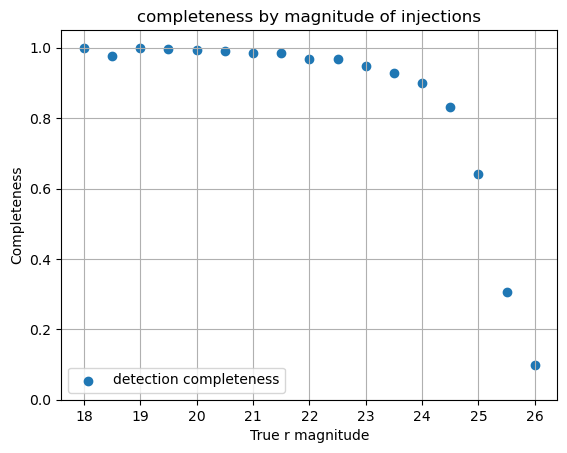

In [24]:
plt.figure()
plt.scatter(bins[:-1], proportionsMag, label="detection completeness")
plt.xlabel("True r magnitude")
plt.title("completeness by magnitude of injections")
plt.ylabel("Completeness")
plt.legend()
plt.ylim(0, 1.05)
plt.grid()
plt.show()

# Get the WL subsample 

## Prepare sample (qual cuts, mask, RS removal, WL cuts)

### take the catalog: convert to mag, add sepearation column

bands: which are included already in the catalog ... 

b = griz 

'{b}_cModelFlux'
'{b}_gaap1p0Flux'
'{b}_psfFlux'

In [12]:
cluster_coords = (37.86501659859067, 6.982204815599694)
ra_bcg, dec_bcg = cluster_coords

def convertUnits(catalog): 
    for b in bands:
        catalog[f'{b}_cModel_mag'] = u.nJy.to(u.ABmag, catalog[f'{b}_cModelFlux'])
        catalog[f'{b}_gaap_mag'] = u.nJy.to(u.ABmag, catalog[f'{b}_gaap1p0Flux'])
        catalog[f'{b}_psf_mag'] = u.nJy.to(u.ABmag, catalog[f'{b}_psfFlux'])

    return catalog

def convertSkyCoordinatesToDegrees(catalog, cluster_coords):
    #c1 = SkyCoord(catalog['coord_ra']*u.deg, catalog['coord_dec']*u.deg)
    c1 = SkyCoord(catalog['coord_ra']*u.deg, catalog['coord_dec']*u.deg)

    c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
    sep = c1.separation(c2)
    catalog['sep'] = sep.deg

    return catalog


In [13]:
magCatalog = convertUnits(combined)
sepCatalog = convertSkyCoordinatesToDegrees(magCatalog, cluster_coords)

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [14]:
print(len(sepCatalog))

1150043


add the resolution for the WL filter - need shape xx and shape yy 
ixxPSF and iyy PSF 

### Examine the distribution of items in sepCatalog (ra/dec and sep)

matched obj are syntehtic obj detected and real obj

need coord_ra and coord_dec which are both in the catalog ... 

all obj is real + synthetic detected + synthetic not detected
matched obj is synthetic detected + real


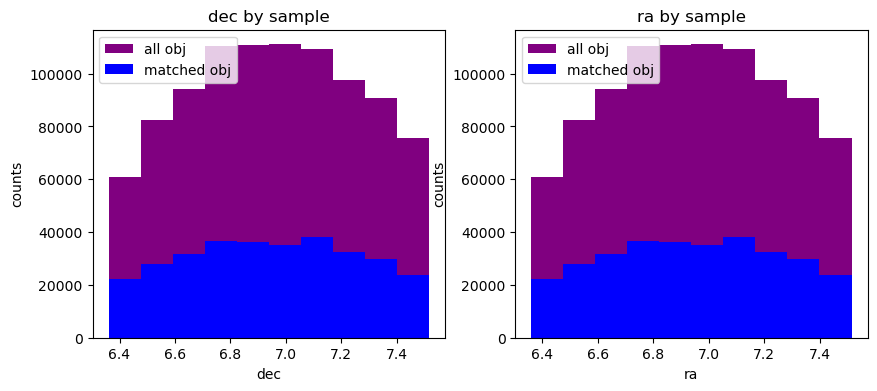

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(sepCatalog['ref_dec'], color='purple', label="all obj")
ax[0].hist(sepCatalog['coord_dec'], color='blue', label='matched obj')
ax[0].set_title("dec by sample") 
ax[0].set_ylabel("counts")
ax[0].set_xlabel("dec")
ax[0].legend()

ax[1].hist(sepCatalog['ref_dec'], color='purple', label="all obj")
ax[1].hist(sepCatalog['coord_dec'], color='blue', label='matched obj')
ax[1].set_title("ra by sample")
ax[1].set_ylabel("counts")
ax[1].set_xlabel("ra")
ax[1].legend()

print('all obj is real + synthetic detected + synthetic not detected')
print('matched obj is synthetic detected + real')

number in entire catalog 1150043
number real 206890
number inject 943153
all = real + inj
real is only real obj
inj is only injected obj


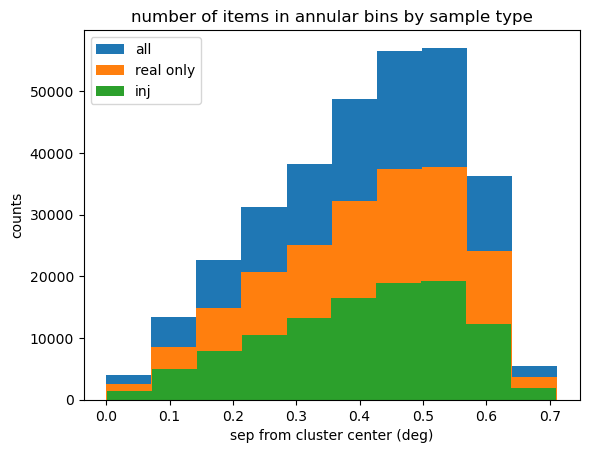

In [16]:
injectedmaskcolumn = sepCatalog["ref_r_comp1_source_type"]
injectedmaskcolumnmask = injectedmaskcolumn.mask 
onlyNonInjectedObjects = sepCatalog[injectedmaskcolumnmask]
inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
onlyInjectedObjects = sepCatalog[inverseinjectedmaskcolumnmask]

print("number in entire catalog", len(sepCatalog))
print("number real", len(onlyNonInjectedObjects))
print("number inject", len(onlyInjectedObjects))

plt.hist(sepCatalog['sep'], label='all')
plt.hist(onlyNonInjectedObjects['sep'], label='real only')
plt.hist(onlyInjectedObjects['sep'], label='inj')
plt.title('number of items in annular bins by sample type')
plt.ylabel('counts')
plt.xlabel('sep from cluster center (deg)')
plt.legend()

print('all = real + inj')
print('real is only real obj')
print('inj is only injected obj')

In [82]:
def plotOccupany(catalog, extendednessBoolean, printOccupancyBoolean, maskBoolean, otherMarker):
    extendednessLabel = "ext>0" 
    maskLabel = "no mask" 
    otherMarkerlabel = ""

    if otherMarker: 
        otherMarkerlabel = "QC+WL"

    # get the column responsible for if the object is injected 
    injectedmaskcolumn = catalog["ref_r_comp1_source_type"]
    injectedmaskcolumnmask = injectedmaskcolumn.mask 
    
    # get the "real" obj 
    onlyNonInjectedObjects = catalog[injectedmaskcolumnmask]
    inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask

    # get the injected obj 
    onlyInjectedObjects = catalog[inverseinjectedmaskcolumnmask]

    if extendednessBoolean: 
        allExtendedObjMask = catalog['refExtendedness'] >= 0.5
        catalog = catalog[allExtendedObjMask]
        
        realExtendedMask = onlyNonInjectedObjects['refExtendedness'] >= 0.5
        onlyNonInjectedObjects = onlyNonInjectedObjects[realExtendedMask]
        
        injExtendedMask = onlyInjectedObjects['refExtendedness'] >= 0.5
        onlyInjectedObjects = onlyInjectedObjects[injExtendedMask]

        extendednessLabel = "ext>0.5" 

    if printOccupancyBoolean:
        print("number in entire catalog", len(catalog))
        print("number real", len(onlyNonInjectedObjects))
        print("number inject", len(onlyInjectedObjects))

    if maskBoolean: 
        maskLabel = "mask" 

    bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
    binsMpc = bins_mpc
    binsdegrees = getBinsDegrees(binsMpc)
    
    allCounts, bins = np.histogram(catalog['sep'], binsdegrees)
    realCounts, bins = np.histogram(onlyNonInjectedObjects['sep'], binsdegrees)
    injCounts, bins = np.histogram(onlyInjectedObjects['sep'], binsdegrees)

    plt.scatter(binsMpc[:-1], allCounts, label='all')
    plt.scatter(binsMpc[:-1], realCounts, label='real only')
    plt.scatter(binsMpc[:-1], injCounts, label='inj')
    plt.title(f'number of items in annular bins by sample type, {extendednessLabel} + {maskLabel}, {otherMarkerlabel}')
    plt.ylabel('counts')
    plt.xlabel('sep from cluster center (deg)')
    plt.yscale('log')
    plt.legend()

number in entire catalog 1150043
number real 206890
number inject 943153


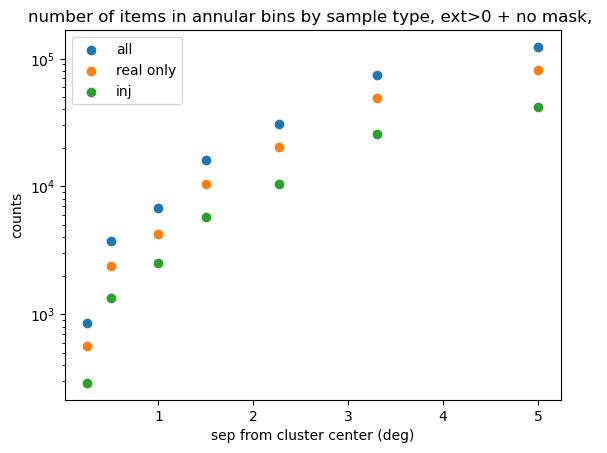

In [83]:
plotOccupany(sepCatalog, False, True, False, False)

number in entire catalog 214455
number real 139115
number inject 75340


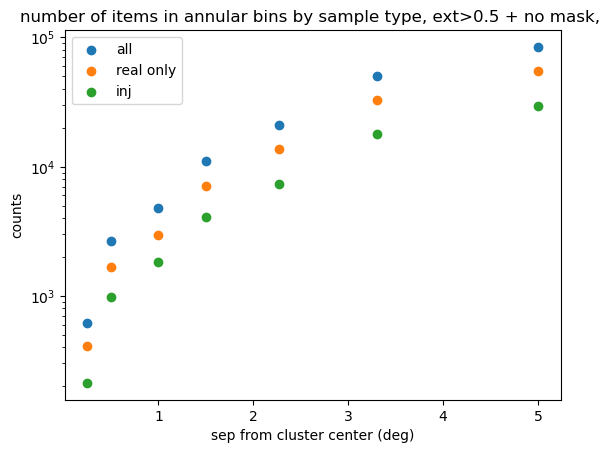

In [84]:
plotOccupany(sepCatalog, True, True, False, False)

### Examine the raw injection density for the entire field 

later is shown that the density of injected galaxies in the masked field drops slightly for the first few radial bins, want to see if this is inherent in the dataset 

In [93]:
def plotDensity(catalog, extendednessBoolean, printOccupancyBoolean, maskBoolean, otherMarker):
    extendednessLabel = "ext>0" 
    maskLabel = "no mask" 
    otherMarkerlabel = ""

    if otherMarker: 
        otherMarkerlabel = "QC+WL"
        
    # get the column responsible for if the object is injected 
    injectedmaskcolumn = catalog["ref_r_comp1_source_type"]
    injectedmaskcolumnmask = injectedmaskcolumn.mask 
    
    # get the "real" obj 
    onlyNonInjectedObjects = catalog[injectedmaskcolumnmask]
    inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask

    # get the injected obj 
    onlyInjectedObjects = catalog[inverseinjectedmaskcolumnmask]

    if extendednessBoolean: 
        allExtendedObjMask = catalog['refExtendedness'] >= 0.5
        catalog = catalog[allExtendedObjMask]
        
        realExtendedMask = onlyNonInjectedObjects['refExtendedness'] >= 0.5
        onlyNonInjectedObjects = onlyNonInjectedObjects[realExtendedMask]
        
        injExtendedMask = onlyInjectedObjects['refExtendedness'] >= 0.5
        onlyInjectedObjects = onlyInjectedObjects[injExtendedMask]

        extendednessLabel = "ext>0.5" 


    bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
    binsMpc = bins_mpc
    binsdegrees = getBinsDegrees(binsMpc)
    areas, binsdegrees = getAreaFull(binsMpc)
    
    if maskBoolean:  
        areas = []
        proportions = []
        for x in range(len(binsdegrees[:-1])):
            if x == 0: 
                effectiveareaarcmin, proportion = getUnmaskedArea(binsdegrees[x], binsdegrees[x+1], int(1e5), False)
                areas.append(effectiveareaarcmin)
                proportions.append(proportion)
            else: 
                effectiveareaarcmin, proportion = getUnmaskedArea(binsdegrees[x], binsdegrees[x+1], int(1e5), False)
                areas.append(effectiveareaarcmin)
                proportions.append(proportion)
        
        maskLabel = "mask" 
    
    ## get the counts in each bin 
    
    allObjectsCounts, bins = np.histogram(catalog['sep'], bins = binsdegrees)
    allRealObjectsCounts, bins = np.histogram(onlyNonInjectedObjects['sep'], bins = binsdegrees)
    allInjObjectsCounts, bins = np.histogram(onlyInjectedObjects['sep'], bins = binsdegrees)
    
    ## get the uncertinaity in each bin 
    uncertAll = getDensityErrorPoissonCountOnly(allObjectsCounts, areas)
    uncertReal = getDensityErrorPoissonCountOnly(allRealObjectsCounts, areas)
    uncertInj = getDensityErrorPoissonCountOnly(allInjObjectsCounts, areas)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    ax.errorbar(binsMpc[:-1], allObjectsCounts/areas, yerr=uncertAll, fmt='o', capsize=3, label='real + inj')
    ax.errorbar(binsMpc[:-1], allRealObjectsCounts/areas, yerr=uncertReal, fmt='o', capsize=3, label='real only')
    ax.errorbar(binsMpc[:-1], allInjObjectsCounts/areas, yerr=uncertInj, fmt='o', capsize=3, label='inj only')
    
    plt.title(f'density of items in annular bins by sample type, {extendednessLabel} + {maskLabel}, {otherMarkerlabel}')
    plt.ylabel('density (count/arc min**2)')
    plt.xlabel('sep from cluster center (Mpc)')
    plt.legend()

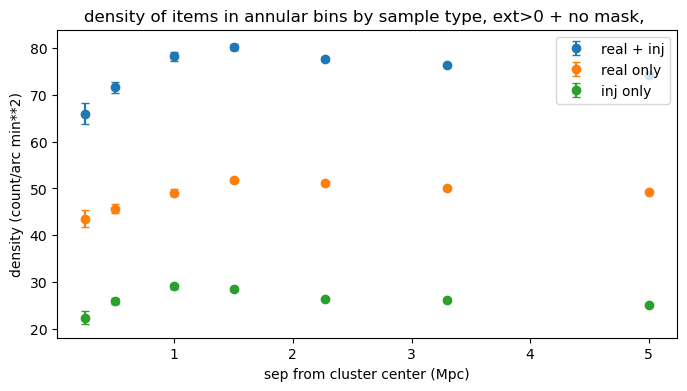

In [94]:
plotDensity(sepCatalog, False, True, False, False)

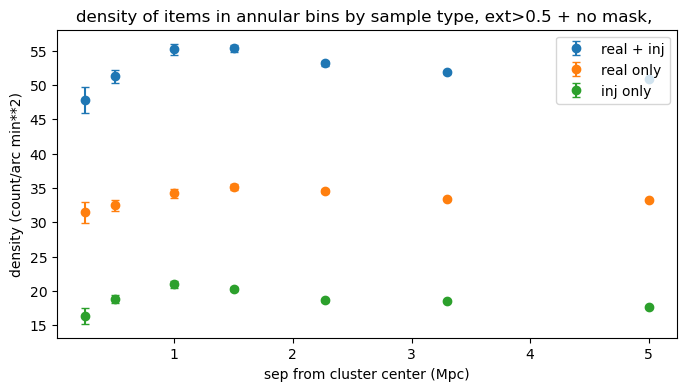

In [96]:
plotDensity(sepCatalog, True, True, False, False)

### Examine the mag of the entire catalog  

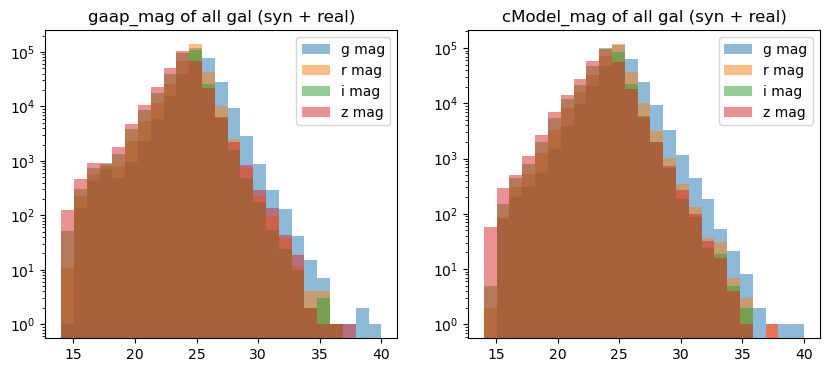

In [45]:
usebins = np.linspace(14, 40, 26)  # 29 bins

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(sepCatalog["g_gaap_mag"], bins = usebins, label='g mag', alpha=0.5)
ax[0].hist(sepCatalog["r_gaap_mag"], bins = usebins, label='r mag', alpha=0.5)
ax[0].hist(sepCatalog["i_gaap_mag"], bins = usebins, label='i mag', alpha=0.5)
ax[0].hist(sepCatalog["z_gaap_mag"], bins = usebins, label='z mag', alpha=0.5)
ax[0].legend()
ax[0].set_title("gaap_mag of all gal (syn + real)")
ax[0].set_yscale('log')

ax[1].hist(sepCatalog["g_cModel_mag"], bins = usebins, label='g mag', alpha=0.5)
ax[1].hist(sepCatalog["r_cModel_mag"], bins = usebins, label='r mag', alpha=0.5)
ax[1].hist(sepCatalog["i_cModel_mag"], bins = usebins, label='i mag', alpha=0.5)
ax[1].hist(sepCatalog["z_cModel_mag"], bins = usebins, label='z mag', alpha=0.5)
ax[1].legend()
ax[1].set_title("cModel_mag of all gal (syn + real)")
ax[1].set_yscale('log')

In [137]:
sepCatalog.write("SSIsepCatalog.fits", overwrite=True)

### Apply the mask (remove items which are in the masked out areas)

In [48]:
def get_masks(table, filename):
    mask_hsp =hsp.HealSparseMap.read(f'{filename}.parquet')
    mask = ~mask_hsp['full_mask'].get_values_pos(table['coord_ra'], table['coord_dec'], lonlat=True)
    return mask

In [49]:
maskfile = '/home/b/bclevine/A360/A360_full_mask_hsp_128_131072'

mask = ~mask_hsp['full_mask'].get_values_pos(sepCatalog['coord_ra'], sepCatalog['coord_dec'], lonlat=True)
table_mask = get_masks(sepCatalog, maskfile)
maskedcatalog = sepCatalog[table_mask]

In [22]:
# save the masked catalog 

maskedcatalog.write("SSIMaskedCat.fits", overwrite=True)

In [50]:
print(len(maskedcatalog))

1074586


In [51]:
table = maskedcatalog

number in entire catalog 1074586
number real 156056
number inject 918530


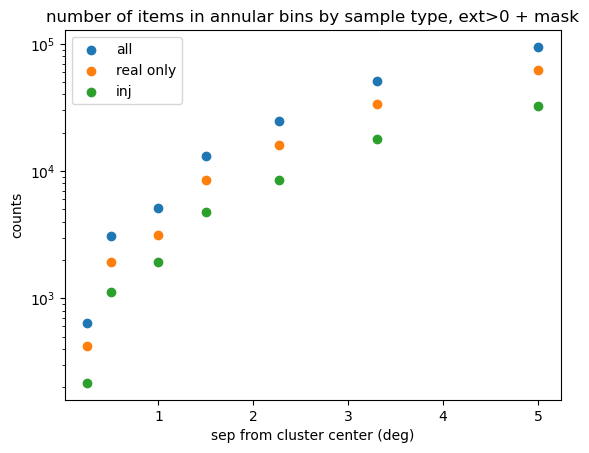

In [57]:
plotOccupany(maskedcatalog, False, True, True, False)

number in entire catalog 166470
number real 108316
number inject 58154


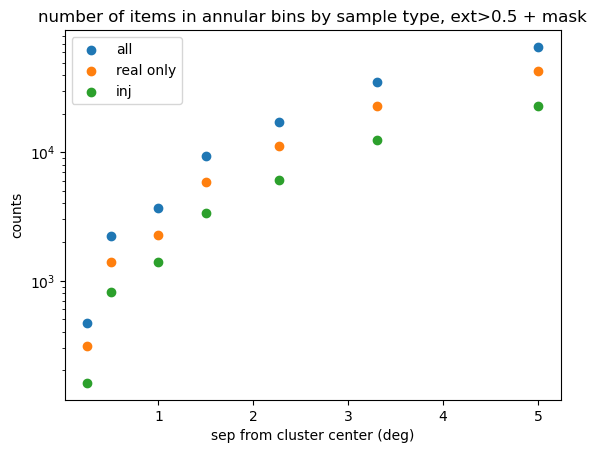

In [58]:
plotOccupany(maskedcatalog, True, True, True, False)

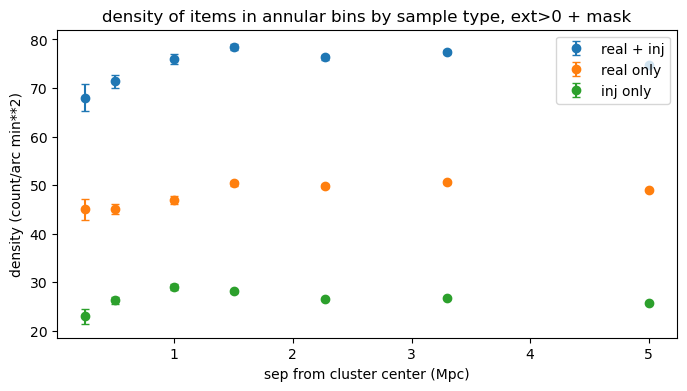

In [60]:
plotDensity(maskedcatalog, False, True, True, False)

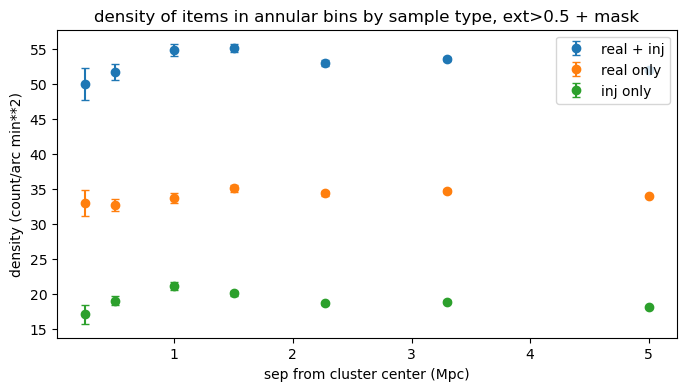

In [59]:
plotDensity(maskedcatalog, True, True, True, False)

### Begin WL and RS cuts - application of quality cuts 

flag not in the table = 'i_iPSF_flag', 'i_hsmShapeRegauss_flag'

In [61]:
quality_flags = ['i_iPSF_flag', 'i_hsmShapeRegauss_flag', 'g_cModel_flag', 
                 'r_cModel_flag', 'i_cModel_flag', 'z_cModel_flag',
                 'g_gaapFlux_flag', 'r_gaapFlux_flag', 'i_gaapFlux_flag', 'z_gaapFlux_flag']

flagsindata = ['g_cModel_flag', 'r_cModel_flag', 'i_cModel_flag', 'z_cModel_flag', 'g_gaapFlux_flag', 'r_gaapFlux_flag', 'i_gaapFlux_flag', 'z_gaapFlux_flag']

flagsnotindata = ['i_iPSF_flag', 'i_hsmShapeRegauss_flag'] 

In [62]:
quality_flags = ['i_iPSF_flag', 'i_hsmShapeRegauss_flag', 'g_cModel_flag', 'r_cModel_flag', 'i_cModel_flag', 'z_cModel_flag',
                 'g_gaapFlux_flag', 'r_gaapFlux_flag', 'i_gaapFlux_flag', 'z_gaapFlux_flag']
print(f"For flag 'refExtendedness', there are {np.sum(np.isnan(maskedcatalog['refExtendedness']))} bad objects")

for qf in flagsindata:
    print(f"For flag '{qf}', there are {np.sum(maskedcatalog[qf] == True)} bad objects")


For flag 'refExtendedness', there are 0 bad objects
For flag 'g_cModel_flag', there are 2429 bad objects
For flag 'r_cModel_flag', there are 2532 bad objects
For flag 'i_cModel_flag', there are 2386 bad objects
For flag 'z_cModel_flag', there are 2152 bad objects
For flag 'g_gaapFlux_flag', there are 0 bad objects
For flag 'r_gaapFlux_flag', there are 0 bad objects
For flag 'i_gaapFlux_flag', there are 13 bad objects
For flag 'z_gaapFlux_flag', there are 0 bad objects


In [63]:
# editted from the Source Selection to remove the "shape flag", 'i_iPSF_flag', 'i_hsmShapeRegauss_flag'

def preclean_filt(preclean_table):
    clean_filt = np.logical_and.reduce((~np.isnan(preclean_table['refExtendedness']),
                                        ~preclean_table['g_cModel_flag'], ~preclean_table['r_cModel_flag'], ~preclean_table['i_cModel_flag'], ~preclean_table['z_cModel_flag'],
                                        ~preclean_table['g_gaapFlux_flag'], ~preclean_table['r_gaapFlux_flag'], ~preclean_table['i_gaapFlux_flag'], ~preclean_table['z_gaapFlux_flag']))
    return clean_filt


In [64]:
qualitycutcatalogfilter = preclean_filt(maskedcatalog)
qualitycutcatalog = maskedcatalog[qualitycutcatalogfilter]

In [65]:
print(len(qualitycutcatalog))

215120


In [66]:
table = qualitycutcatalog

number in entire catalog 215120
number real 138538
number inject 76582


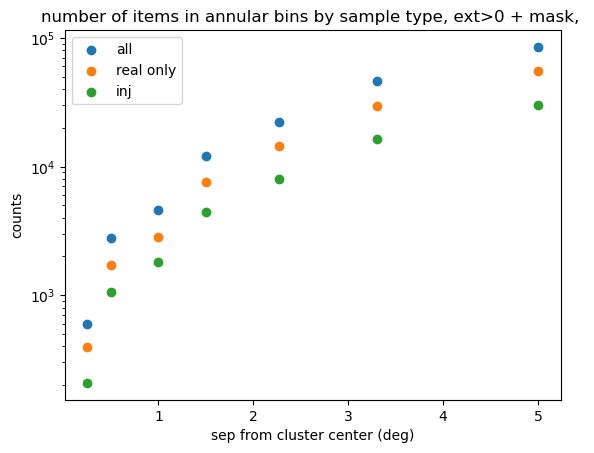

In [86]:
plotOccupany(qualitycutcatalog, False, True, True, False)

### Add mag differences 

In [69]:
gi = table['g_gaap_mag'] - table['i_gaap_mag']
ri = table['r_gaap_mag'] - table['i_gaap_mag']
gr = table['g_gaap_mag'] - table['r_gaap_mag']

table['gi'] = gi
table['ri'] = ri
table['gr'] = gr

In [70]:
for b in list('griz'):
    snr = table[f'{b}_cModelFlux']/table[f'{b}_cModelFluxErr']
    filt = np.logical_and(snr > 5, snr < 6)
    depth = np.nanmean(table[f'{b}_cModel_mag'][filt])
    print(f"band {b} with depth: {depth:0.2f} w/ N={np.sum(filt)}")

band g with depth: 25.21 w/ N=22537
band r with depth: 24.91 w/ N=22974
band i with depth: 24.63 w/ N=20625
band z with depth: 23.20 w/ N=11491


In [71]:
gi_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - table['i_gaap1p0FluxErr']))
gi_pos = -2.5*np.log10((table['g_gaap1p0Flux'] + table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] + table['i_gaap1p0FluxErr']))

/tmp/ipykernel_3839/2074801087.py:1: RuntimeWarning: invalid value encountered in log10
  gi_neg = -2.5*np.log10((table['g_gaap1p0Flux'] - table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] - table['i_gaap1p0FluxErr']))
/tmp/ipykernel_3839/2074801087.py:2: RuntimeWarning: invalid value encountered in log10
  gi_pos = -2.5*np.log10((table['g_gaap1p0Flux'] + table['g_gaap1p0FluxErr'])/(table['i_gaap1p0Flux'] + table['i_gaap1p0FluxErr']))


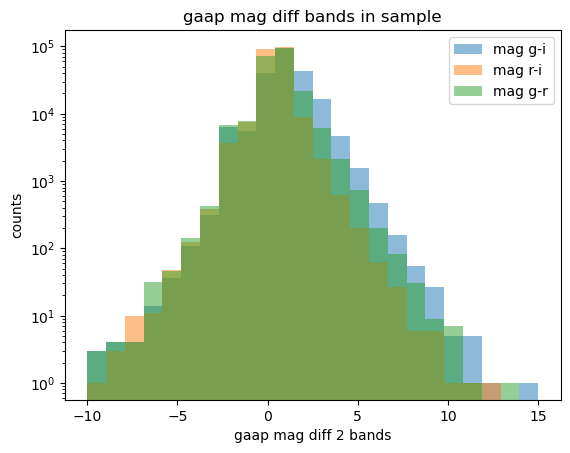

In [72]:
usebins = np.linspace(-10, 15, 25)

plt.hist(table['gi'], bins = usebins, label='mag g-i', alpha=0.5)
plt.hist(table['ri'], bins = usebins, label='mag r-i', alpha=0.5)
plt.hist(table['gr'], bins = usebins, label='mag g-r', alpha=0.5)
plt.ylabel("counts")
plt.xlabel("gaap mag diff 2 bands")
plt.yscale('log')
plt.title("gaap mag diff bands in sample")
plt.legend()

### Apply the RS identifier 

In [73]:
def apply_redsequence_noisy(table, mag_lim = 23.5, bright_lim=18, sigma=2, delta=0.05):
    
    gi_table_line = (table['i_cModel_mag'] - 18) * (-0.2/5) + 1.9
    ri_table_line = (table['i_cModel_mag'] - 18) * (-0.1/5) + .55
    gr_table_line = (table['i_cModel_mag'] - 18) * (-0.25/5) + 1.35

    gi_lims = (0.1 + delta, -.25 - delta)
    ri_lims = (0.04 + delta, -0.08 - delta)
    gr_lims = (0.1 + delta, -.15 - delta)
    
    g_mag_err = 2.5/np.log(10) * table['g_gaap1p0FluxErr']/table['g_gaap1p0Flux']
    r_mag_err = 2.5/np.log(10) * table['r_gaap1p0FluxErr']/table['r_gaap1p0Flux']
    i_mag_err = 2.5/np.log(10) * table['i_gaap1p0FluxErr']/table['i_gaap1p0Flux']
    
    gi_err = np.sqrt(g_mag_err**2 + i_mag_err**2)
    gr_err = np.sqrt(g_mag_err**2 + r_mag_err**2)
    ri_err = np.sqrt(r_mag_err**2 + i_mag_err**2)
    
    table['gi'] = table['g_gaap_mag'] - table['i_gaap_mag']
    table['ri'] = table['r_gaap_mag'] - table['i_gaap_mag']
    table['gr'] = table['g_gaap_mag'] - table['r_gaap_mag']

    gi_plus = table['gi'] + sigma*gi_err
    ri_plus = table['ri'] + sigma*ri_err
    gr_plus = table['gr'] + sigma*gr_err

    gi_minus = table['gi'] - sigma*gi_err
    ri_minus = table['ri'] - sigma*ri_err
    gr_minus = table['gr'] - sigma*gr_err
    
    table['gi_plus'] = gi_plus
    table['ri_plus'] = ri_plus
    table['gr_plus'] = gr_plus

    table['gi_neg'] = gi_minus
    table['ri_neg'] = ri_minus
    table['gr_neg'] = gr_minus

    rs_table_lines = [gi_table_line, ri_table_line, gr_table_line]
    rs_lims = [gi_lims, ri_lims, gr_lims]
    rs_table_upper = [t+l[0] for t,l in zip(rs_table_lines, rs_lims)]
    rs_table_lower = [t+l[1] for t,l in zip(rs_table_lines, rs_lims)]
    table_plus = [gi_plus, ri_plus, gr_plus]
    table_neg = [gi_minus, ri_minus, gr_minus]

    redsequences = []
    for i,cc in enumerate(['gi', 'ri', 'gr']):
        redseq = np.logical_and.reduce((table[cc] < rs_table_upper[i], table[cc] > rs_table_lower[i],
                                         table['i_cModel_mag'] < 28, table['i_cModel_mag'] > bright_lim))
        redseq_err = np.logical_or.reduce((
                                           np.logical_and.reduce((table_plus[i] > rs_table_upper[i],
                                                                  rs_table_lower[i] < table_neg[i],
                                                                  table_neg[i] < rs_table_upper[i])),
                                           np.logical_and.reduce((table_neg[i] < rs_table_lower[i],
                                                                  rs_table_lower[i] < table_plus[i],
                                                                  table_plus[i] < rs_table_upper[i])),
                                           np.logical_and(table_plus[i] > rs_table_upper[i],
                                                          table_neg[i] < rs_table_lower[i])
                                         ))
        # redseq_err = np.logical_and(table_plus[i] > rs_table_upper[i], table_neg[i] < rs_table_lower[i])
        fin_redseq = np.logical_or(redseq, redseq_err)
        redsequences.append(fin_redseq)


    all_redseq = np.logical_and.reduce(redsequences)
    table['all_redseq'] = all_redseq
    # For individual colors we should add a magnitude limit since it's more likely for source galaxies to be located in at least one color
    
    table['gi_redseq'] = np.logical_and(redsequences[0], table['i_cModel_mag'] < mag_lim)
    table['ri_redseq'] = np.logical_and(redsequences[1], table['i_cModel_mag'] < mag_lim)
    table['gr_redseq'] = np.logical_and(redsequences[2], table['i_cModel_mag'] < mag_lim)

    return table

In [74]:
delta = 0.05
table = apply_redsequence_noisy(table, sigma=1, mag_lim=23.76, bright_lim=18, delta=delta)

In [75]:
print(len(table))

215120


165787


Text(0.5, 0.01, 'cModel $i$-mag')

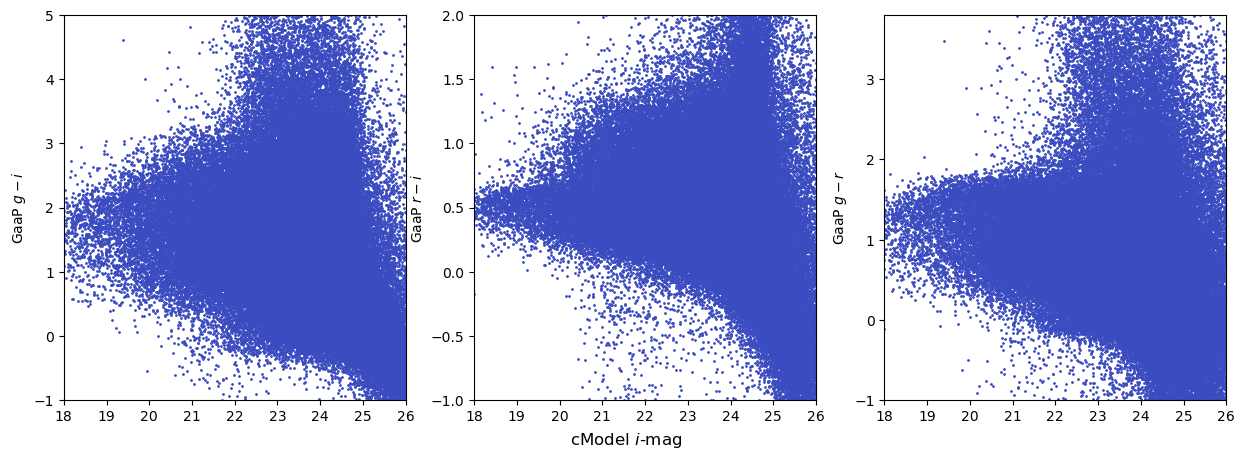

In [76]:
# We can identify the cluster members by plotting a color magnitude diagram 
# want extended items and with separation less than 3/60 (0.05) 

fig, ax = plt.subplots(ncols=3, figsize=(15, 5)) 

rs_table = table[np.logical_and(table['sep'] < 1, table['refExtendedness']==1)]
print(len(rs_table))

color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
cmap = cm.coolwarm
for i in range(3):
    col = color_names[i]
    ax[i].scatter(rs_table['i_cModel_mag'], rs_table[col], marker='.', s=4, color=cmap(0))
    # ax[i].scatter(rs_table['r_cModel_mag'], rs_table[col], c=rs_table['sep'], marker='.', s=4)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)

fig.supxlabel(r"cModel $i$-mag")

19077 33124 23693
165787


Text(0.5, 0.01, 'cModel $i$-mag')

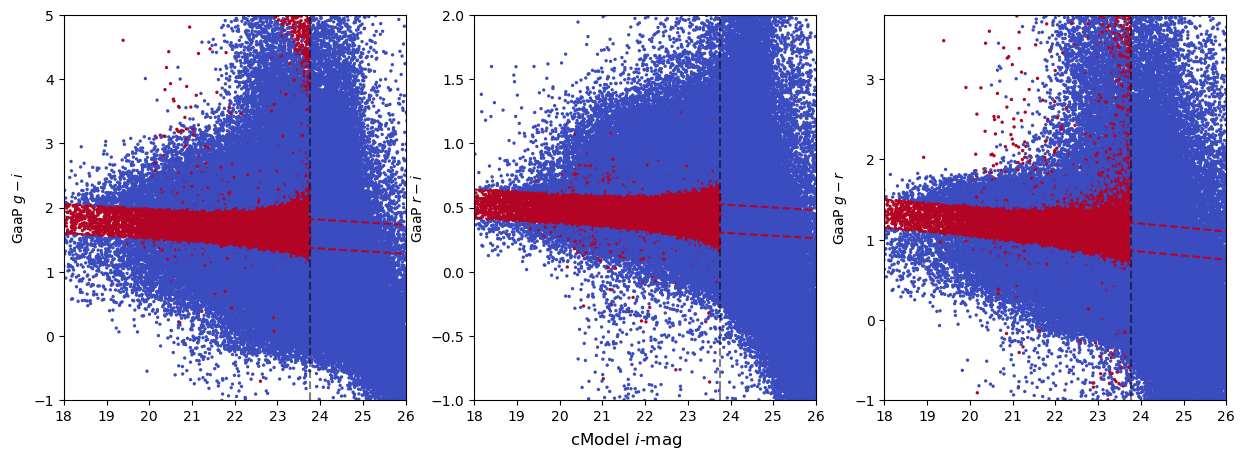

In [77]:
# add boundaries to the above plot 
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

rs_table = table[np.logical_and(table['sep'] < 1, table['refExtendedness']==1)]
print(np.sum(rs_table['gi_redseq']), np.sum(rs_table['ri_redseq']), np.sum(rs_table['gr_redseq']))
print(len(rs_table))

cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    col_filt = rs_table[f'{col}_redseq']
    # col_filt = np.logical_or(redseq_err[i], rs_table[f'{col}_redseq'])
    ax[i].scatter(rs_table['i_cModel_mag'], rs_table[col], marker='.', s=8, c=col_filt, cmap=cmap)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)
    # ax[i].axvline(20, ls='--', color='k', alpha=0.5)
    ax[i].axvline(23.76, ls='--', color='k', alpha=0.5)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)

ax[0].axline((18, 1.9+0.1 + delta), slope=-0.2/5, ls='--', color=cmap(1.0))
ax[0].axline((18, 1.9-0.25 - delta), slope=-0.2/5, ls='--', color=cmap(1.0))

ax[1].axline((18, .55+0.04 + delta), slope=-0.1/5, ls='--', color=cmap(1.0))
ax[1].axline((18, .55-0.08 - delta), slope=-0.1/5, ls='--', color=cmap(1.0))

ax[2].axline((18, 1.35+0.1 + delta), slope=-0.25/5, ls='--', color=cmap(1.0))
ax[2].axline((18, 1.35-0.15 - delta), slope=-0.25/5, ls='--', color=cmap(1.0))

fig.supxlabel(r"cModel $i$-mag")


### Apply first WL cut

In [78]:
def get_wlfilt(table, mag_lim=24, bright_lim=20, SNR=10, apply_sep=True, apply_extend=True):
    filt = table['g_cModel_flag']== False
    filt &= table['r_cModel_flag']== False
    filt &= table['i_cModel_flag']== False
    filt &= (table['i_cModel_mag'] <= mag_lim)
    filt &= (table['i_cModel_mag'] >= bright_lim)
    filt &= (table['i_cModelFlux']/table['i_cModelFluxErr']) >= SNR
    #filt &= ~(table['i_hsmShapeRegauss_flag'])
    #filt &= (table['i_hsmShapeRegauss_e1']**2 + table['i_hsmShapeRegauss_e2']**2) <= 4
    #filt &= table['res'] >= 0.3
    #filt &= table['i_blendedness'] <= 0.42
    #filt &= (table['i_hsmShapeRegauss_sigma']<= 0.4) * (0 < table['i_hsmShapeRegauss_sigma'])
    #filt &= table['i_iPSF_flag']==0
    if apply_sep:
        filt &= table['sep'] < 0.75
    if apply_extend:
        # filt &= table['g_extendedness']==1
        # filt &= table['r_extendedness']==1
        # filt &= table['i_extendedness']==1
        filt &= (table['refExtendedness'] >= 0.5)
    print(f"After WL cuts: {np.sum(filt)}")
    return filt

def get_wlfilt2(table, mag_lim=24, bright_lim=20, SNR=10, apply_sep=True, apply_extend=True):
    filt = table['g_cModel_flag']== False
    filt &= table['r_cModel_flag']== False
    filt &= table['i_cModel_flag']== False
    filt &= (table['i_cModel_mag'] <= mag_lim)
    filt &= (table['i_cModel_mag'] >= bright_lim)
    filt &= (table['i_cModelFlux']/table['i_cModelFluxErr']) >= SNR
    filt &= ~(table['i_hsmShapeRegauss_flag'])
    filt &= (table['i_hsmShapeRegauss_e1']**2 + table['i_hsmShapeRegauss_e2']**2) <= 4
    filt &= table['res'] >= 0.3
    # filt &= table['i_blendedness'] <= 0.42
    filt &= (table['i_hsmShapeRegauss_sigma']<= 0.4) * (0 < table['i_hsmShapeRegauss_sigma'])
    filt &= table['i_iPSF_flag']==0
    if apply_sep:
        filt &= table['sep'] < 0.75
    if apply_extend:
        # filt &= table['g_extendedness']==1
        # filt &= table['r_extendedness']==1
        # filt &= table['i_extendedness']==1
        filt &= (table['refExtendedness'] >= 0.5)
    print(f"After WL cuts: {np.sum(filt)}")
    return filt

In [79]:
wl_filt = get_wlfilt(table, mag_lim=23.76, bright_lim=20, SNR=0, apply_extend=True)
table = table[wl_filt]

After WL cuts: 69630


In [80]:
print(len(table))

69630


number in entire catalog 69630
number real 43576
number inject 26054


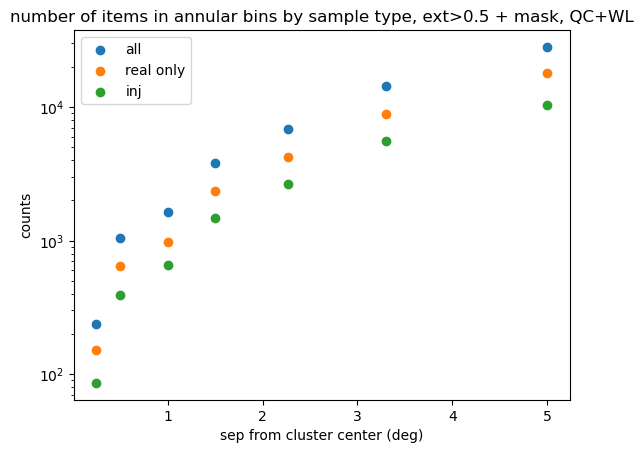

In [87]:
plotOccupany(table, True, True, True, True)

### Apply second WL cut and RS cut

In [88]:
# Apply cuts
cut_types = ['all', 'ri', 'gr', 'gi']
wl_filt2 = get_wlfilt(table, mag_lim=23.76)

for ct in cut_types:
    filt = np.logical_and(wl_filt2,  ~(table[f'{ct}_redseq']))
    print(f"After {ct} cuts: {np.sum(filt)}")
    #source_table = table[filt]
    #source_table.meta = {}
    #source_table.write(f'abell360_POSTCUTS_{ct}noisy_masked_DP1.fits', format="fits", overwrite=True)
    # line below from Prakruth's original
    #source_table.write(f'{outdir}/abell360_POSTCUTS_{ct}noisy_masked_DP1.fits', format="fits", overwrite=True)

After WL cuts: 66943
After all cuts: 59268
After ri cuts: 36823
After gr cuts: 45325
After gi cuts: 49674


In [89]:
alltablemask = np.logical_and(wl_filt2,  ~(table[f'all_redseq']))
alltable = table[alltablemask]

In [90]:
print(len(alltable))

59268


number in entire catalog 59268
number real 36537
number inject 22731


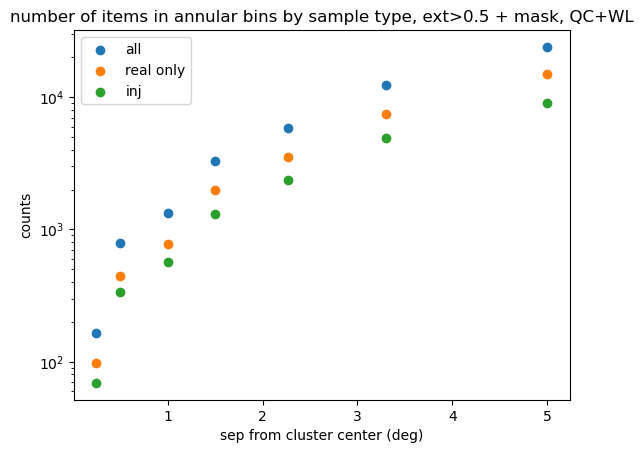

In [91]:
plotOccupany(alltable, True, True, True, True)

In [69]:
## save the table locally for future access, use fits to keep formatting 

table.write("SSIRSRemovalTable.fits", overwrite=True)

In [70]:
tableformat = Table.read("SSIRSRemovalTable.fits")

In [71]:
missing = set(alltable.colnames) - set(tableformat.colnames)
print("Missing columns:", missing)

Missing columns: set()


In [59]:
print(tableformat)

z_kronFlux_flag r_kronFlux g_gaap3p0FluxErr ... ref_tract ref_match_candidate
--------------- ---------- ---------------- ... --------- -------------------
          False  1240.6776        147.58995 ...     10704                True
           True   985.1721        130.20804 ...     10704                True
          False   522.4495       118.498985 ...     10704                True
          False   884.9976        114.21957 ...     10704                True
           True   2048.428        159.74385 ...     10704                True
           True  1044.8253        124.91624 ...     10704                True
          False  24552.361        207.92628 ...     10704                True
          False  140420.98        160.09065 ...     10704                True
          False   258098.2         177.9192 ...     10704                True
          False  6311.2124        137.51244 ...     10704                True
            ...        ...              ... ...       ...       

## Toybox for size vs extendedness denotation 

my goal for this subsection is to see if there is a size as well as extendedness cut in place with the synthetic sources

In [5]:
alltable = Table.read("SSIRSRemovalTable.fits")

In [8]:
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
binsMpc = bins_mpc
binsdegrees = getBinsDegrees(binsMpc)

In [6]:
alltable.columns

<TableColumns names=('z_kronFlux_flag','r_kronFlux','g_gaap3p0FluxErr','r_gaap3p0Flux','sersic_ra','z_cModelFluxErr','r_kronFlux_flag','sersic_reff_yErr','detect_isDeblendedSource','g_gaap1p0Flux_flag_bigPsf','g_kronFlux','r_gaap1p0FluxErr','i_kronFluxErr','sersic_xErr','r_gaapFlux_flag','sersic_indexErr','sersic_reff_xErr','coord_ra','z_gaap1p0Flux_flag_bigPsf','sersic_yErr','i_cModelFluxErr','r_gaap1p0Flux_flag_bigPsf','i_gaap1p0Flux','objectId','z_gaapFlux_flag','sersic_reff_y','sersic_rho','i_cModel_flag','coord_dec','z_kronFluxErr','r_cModelFluxErr','r_kronFluxErr','i_kronFlux','i_kronFlux_flag','sersic_index','sersic_unknown_flag','g_cModelFlux','z_psfFlux','coord_decErr','refSizeExtendedness','i_gaapFlux_flag','detect_isPatchInner','z_psfFluxErr','r_gaap3p0FluxErr','i_sersicFluxErr','g_gaap3p0Flux_flag_bigPsf','sersic_y','sersic_x','g_gaap3p0Flux','r_psfFluxErr','g_cModelFluxErr','z_cModelFlux','z_gaap3p0Flux_flag_bigPsf','sersic_reff_x','sersic_raErr','r_sersicFlux','z_gaap1p0F

In [16]:
def split_cols(cols, substring, case_insensitive=True):
    if case_insensitive:
        substring = substring.lower()
        match = lambda c: substring in c.lower()
    else:
        match = lambda c: substring in c

    matched = [c for c in cols if match(c)]
    unmatched = [c for c in cols if not match(c)]
    return matched, unmatched

In [132]:
matched, unmatched = split_cols(alltable.columns, "mag")
print("matched:", matched)

matched: ['z_cModel_mag', 'z_gaap_mag', 'z_psf_mag', 'i_cModel_mag', 'i_gaap_mag', 'i_psf_mag', 'r_cModel_mag', 'r_gaap_mag', 'r_psf_mag', 'g_cModel_mag', 'g_gaap_mag', 'g_psf_mag']


In [ ]:
matched, unmatched = split_cols(alltable.columns, "flux")
print("matched:", matched)

matched2, unmatched = split_cols(matched, "z")
print("matched:", matched2)

(array([1.8105e+04, 2.7870e+03, 8.9200e+02, 4.3200e+02, 2.7500e+02,
        1.3400e+02, 7.4000e+01, 2.0000e+01, 1.0000e+01, 2.0000e+00]),
 array([8.73311398e+00, 3.16935538e+03, 6.32997764e+03, 9.49059990e+03,
        1.26512222e+04, 1.58118444e+04, 1.89724667e+04, 2.21330890e+04,
        2.52937112e+04, 2.84543335e+04, 3.16149557e+04]),
 <BarContainer object of 10 artists>)

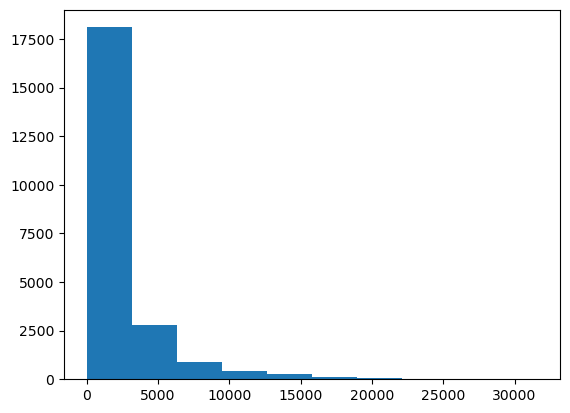

In [135]:
plt.hist(alltable['ref_r_flux'])

In [20]:
matched, unmatched = split_cols(alltable.columns, "extend")
print("matched:", matched)

matched: ['refSizeExtendedness', 'refExtendedness']


In [32]:
matched, unmatched = split_cols(alltable.columns, "ref")
print("matched:", matched)

matched: ['sersic_reff_yErr', 'sersic_reff_xErr', 'sersic_reff_y', 'refSizeExtendedness', 'sersic_reff_x', 'refExtendedness', 'ref_r_injection_flag', 'ref_g_injection_flag', 'ref_r_comp1_source_type', 'ref_g_flux', 'ref_i_injection_flag', 'ref_z_flux', 'ref_z_injection_flag', 'ref_injected_id', 'ref_injected_isPrimary', 'ref_ra', 'ref_injected_isPatchInner', 'ref_r_flux', 'ref_dec', 'ref_i_flux', 'ref_injection_flag', 'ref_injected_isTractInner', 'ref_tract', 'ref_match_candidate']


In [21]:
matched, unmatched = split_cols(alltable.columns, "shape")
print("matched:", matched)

matched: []


In [73]:
matched, unmatched = split_cols(alltable.columns, "size")
print("matched:", matched)

matched: ['refSizeExtendedness']


refSizeExtendedness : moment based measurement of an object to be a galaxy 

In [13]:
def getInjectedCatalog(catalog):
    # get the injected in the masked catalog (before QC, RS, WL) 
    injectedmaskcolumn = catalog["ref_r_comp1_source_type"]
    injectedmaskcolumnmask = injectedmaskcolumn.mask 
    # get only the objects that are injections 
    inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
    injectedObjectsCatalog = catalog[inverseinjectedmaskcolumnmask]

    return injectedObjectsCatalog 

In [14]:
injectedCatalog = getInjectedCatalog(alltable)

In [33]:

# get the original catalog (no cuts) with the mask (denominator) 
maskedcatalog = Table.read("SSIMaskedCat.fits")


In [34]:
maskedInjectedCatalog = getInjectedCatalog(maskedcatalog)

In [109]:
def getHistogramsExtendedness(catalog, catname): 
    fig, ax = plt.subplots(1,2, figsize=(12, 4))

    fig.suptitle(f'{catname}')
    ax[0].hist(catalog['refSizeExtendedness'])
    ax[0].set_title('refSizeExtendedness')
    ax[0].set_ylabel('counts')
    ax[0].set_xlabel('refSizeExtendedness')
    ax[0].set_xlim(-0.25, 1.25)

    ax[1].hist(catalog['refExtendedness'])
    ax[1].set_title('refExtendedness')
    ax[1].set_ylabel('counts')
    ax[1].set_xlabel('refExtendedness')
    ax[1].set_xlim(-0.25, 1.25)


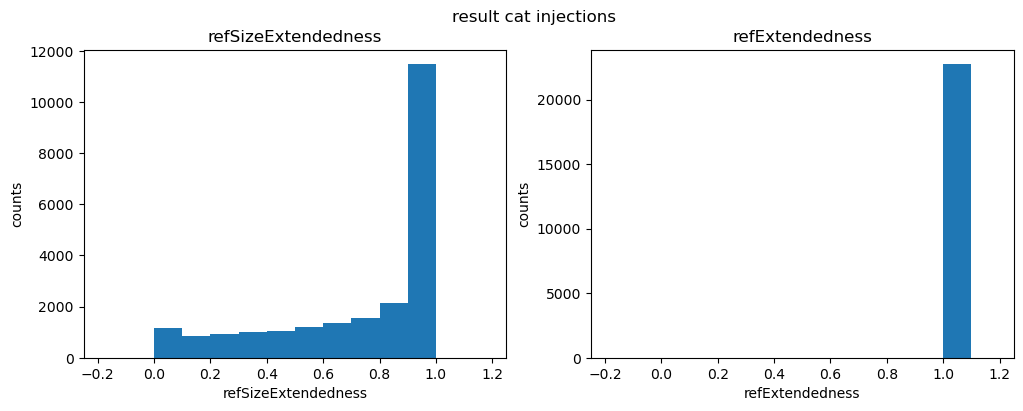

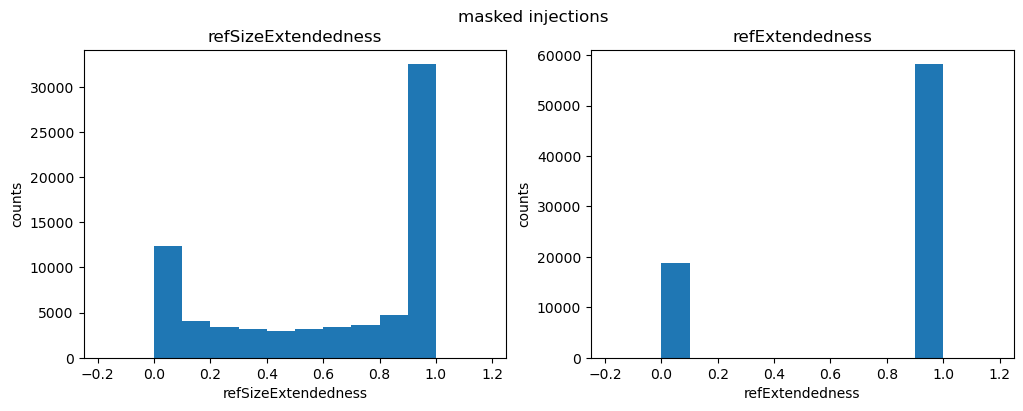

In [110]:
getHistogramsExtendedness(injectedCatalog, 'result cat injections')
getHistogramsExtendedness(maskedInjectedCatalog, 'masked injections')

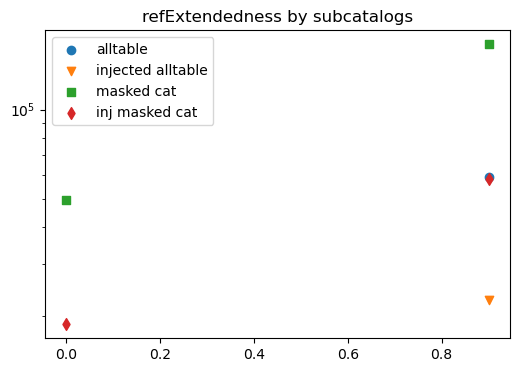

In [122]:
fig, ax = plt.subplots(figsize=(6, 4))

binsspecific = np.arange(0, 1.1, 0.1)
catname = ['alltable', 'injected alltable', 'masked cat', 'inj masked cat']
datasets = [alltable, injectedCatalog, maskedcatalog, maskedInjectedCatalog]
marks = ["o", "v", "s", "d"]
for x in range(len(datasets)):
    counts, bins = np.histogram(datasets[x]['refExtendedness'], bins=binsspecific)
    plt.scatter(binsspecific[:-1], counts, label=f'{catname[x]}', marker=marks[x])

plt.title('refExtendedness by subcatalogs')
ax.legend()
plt.legend()
plt.yscale('log')
plt.show()

==> refExtendedness is 0 or 1 

see if this correlates to refSizeExtendedness boundaries 

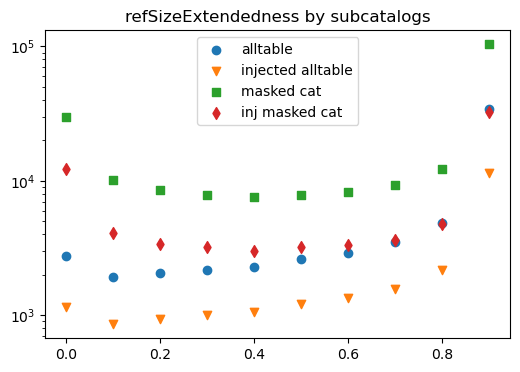

In [123]:
fig, ax = plt.subplots(figsize=(6, 4))

binsspecific = np.arange(0, 1.1, 0.1)
catname = ['alltable', 'injected alltable', 'masked cat', 'inj masked cat']
datasets = [alltable, injectedCatalog, maskedcatalog, maskedInjectedCatalog]
marks = ["o", "v", "s", "d"]
for x in range(len(datasets)):
    counts, bins = np.histogram(datasets[x]['refSizeExtendedness'], bins=binsspecific)
    plt.scatter(binsspecific[:-1], counts, label=f'{catname[x]}', marker=marks[x])

plt.title('refSizeExtendedness by subcatalogs')
ax.legend()
plt.yscale('log')
plt.legend()
plt.show()

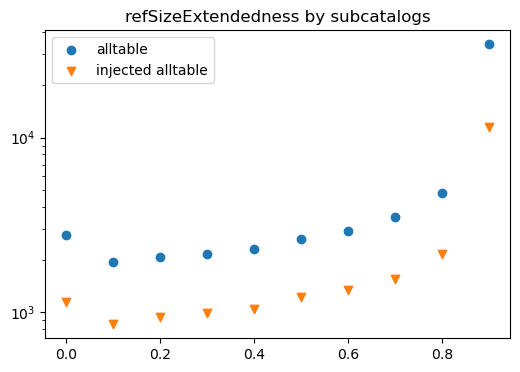

In [121]:
fig, ax = plt.subplots(figsize=(6, 4))

binsspecific = np.arange(0, 1.1, 0.1)
catname = ['alltable', 'injected alltable']
datasets = [alltable, injectedCatalog]
marks = ["o", "v", "s", "d"]
for x in range(len(datasets)):
    counts, bins = np.histogram(datasets[x]['refSizeExtendedness'], bins=binsspecific)
    plt.scatter(binsspecific[:-1], counts, label=f'{catname[x]}', marker=marks[x])

plt.title('refSizeExtendedness by subcatalogs')
plt.yscale('log')
ax.legend()
plt.legend()
plt.show()

the "WL sample" of injected and all, all have a range of refSizeExtendedness values, both in real and injected objects

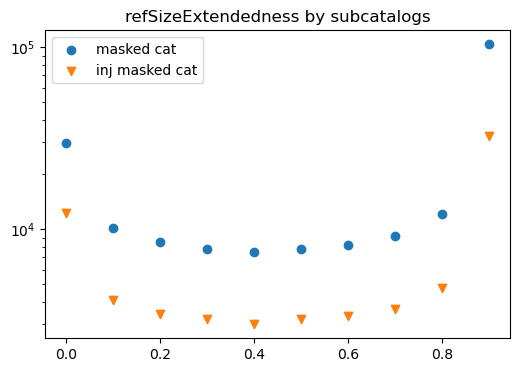

In [125]:
fig, ax = plt.subplots(figsize=(6, 4))

binsspecific = np.arange(0, 1.1, 0.1)
catname = ['masked cat', 'inj masked cat']
datasets = [maskedcatalog, maskedInjectedCatalog]
marks = ["o", "v", "s", "d"]
for x in range(len(datasets)):
    counts, bins = np.histogram(datasets[x]['refSizeExtendedness'], bins=binsspecific)
    plt.scatter(binsspecific[:-1], counts, label=f'{catname[x]}', marker=marks[x])

plt.title('refSizeExtendedness by subcatalogs')
ax.legend()
plt.legend()
plt.yscale('log')
plt.show()

the "masked sample" of injected and all, all have a range of refSizeExtendedness values, both in real and injected objects

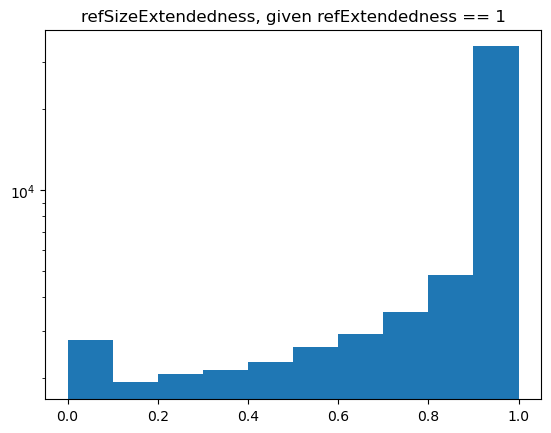

In [128]:
# is there a cutoff, for which a value in refSizeExtendedness would yield refExtendedness 0 or 1? 

refextendedness1mask = alltable['refExtendedness'] == 1 
refextendedness1cat = alltable[refextendedness1mask]

plt.hist(refextendedness1cat['refSizeExtendedness'])
plt.title('refSizeExtendedness, given refExtendedness == 1')
plt.yscale('log')

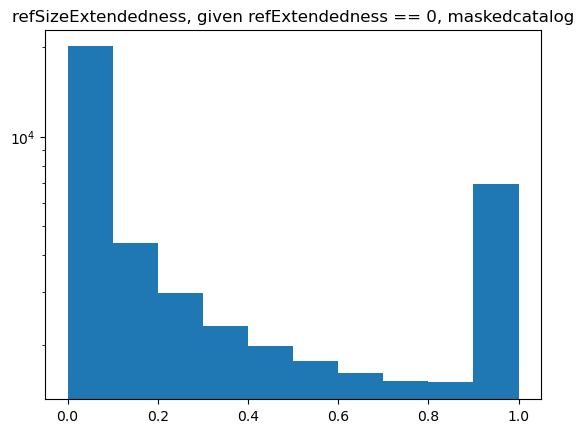

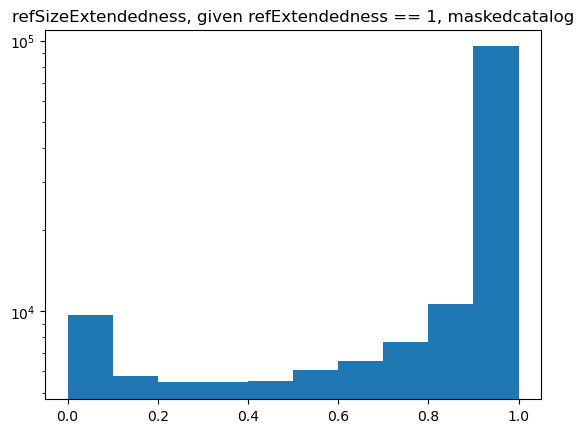

In [131]:
# is there a cutoff, for which a value in refSizeExtendedness would yield refExtendedness 0 or 1? 

refextendedness1mask = maskedcatalog['refExtendedness'] == 0 
refextendedness1cat = maskedcatalog[refextendedness1mask]

plt.hist(refextendedness1cat['refSizeExtendedness'])
plt.title('refSizeExtendedness, given refExtendedness == 0, maskedcatalog')
plt.yscale('log')
plt.show()

# is there a cutoff, for which a value in refSizeExtendedness would yield refExtendedness 0 or 1? 

refextendedness1mask = maskedcatalog['refExtendedness'] == 1 
refextendedness1cat = maskedcatalog[refextendedness1mask]

plt.hist(refextendedness1cat['refSizeExtendedness'])
plt.title('refSizeExtendedness, given refExtendedness == 1, maskedcatalog')
plt.yscale('log')

## Examine using standardized bins

bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])

(have also found binsMpc = np.array([0, .3, .5, 1, 1.5, 2.27, 3.3, 6, 8])) 

In [3]:
alltable = Table.read("SSIRSRemovalTable.fits")

In [4]:
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])

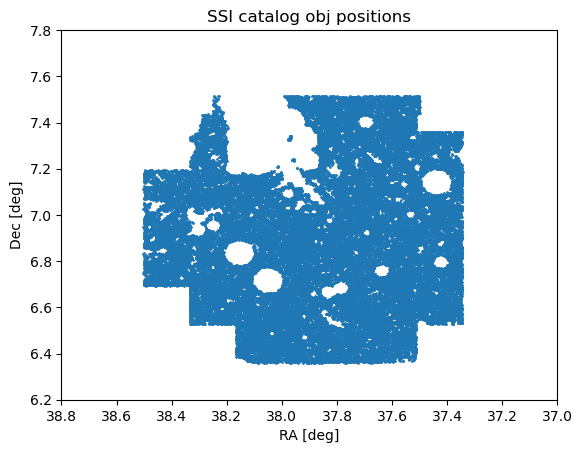

In [99]:
import matplotlib.pyplot as plt

# Example data
ra = [23.676554, 23.6801, 23.6702]
dec = [4.563913, 4.5700, 4.5601]

plt.figure()
plt.scatter(alltable['coord_ra'], alltable['coord_dec'], s=1)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("SSI catalog obj positions")
plt.gca().invert_xaxis()  # standard astronomy convention
plt.ylim(6.2, 7.8)
plt.xlim(38.8, 37)
plt.show()


## How many injectons survive WL cuts by annulus 

plot proportion as function of annulus (# in final sample/total injections) and compare to counts in annulus (# final, # initial)

more detail: Compares the number of galaxy like objects in the final sample to all injections (stars and galaxies) over all magnitudes. 

### Pure counts per annulus 

number in entire catalog 59268
number real 36537
number inject 22731


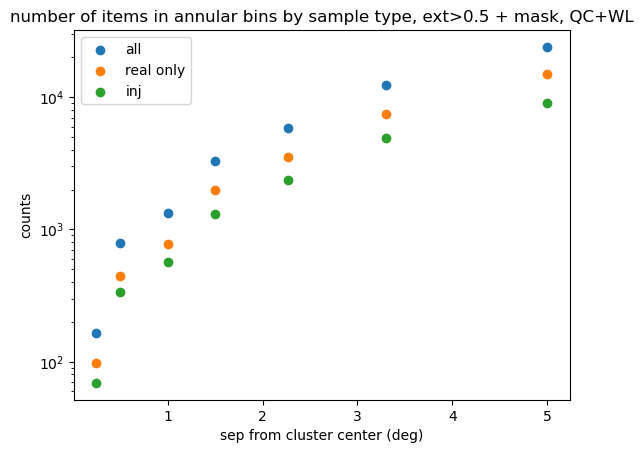

In [100]:
plotOccupany(alltable, True, True, True, True)

plot comparing the number of injected and "true" galaxies within the sample, with the count increasing as a function of radius from the center of the cluster

### raw proportion (#survived/ all injected stars + galaxies)

In [103]:
def getSampleDesired(catalog, binsdegrees):
    # get the injected in the masked catalog (before QC, RS, WL) 
    injectedmaskcolumn = catalog["ref_r_comp1_source_type"]
    injectedmaskcolumnmask = injectedmaskcolumn.mask 
    # get only the objects that are injections 
    inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
    injectedObjectsCatalog = catalog[inverseinjectedmaskcolumnmask]
    
    # number of injected objects before cuts 
    counts, bins = np.histogram(injectedObjectsCatalog['sep'], bins = binsdegrees)

    return counts 

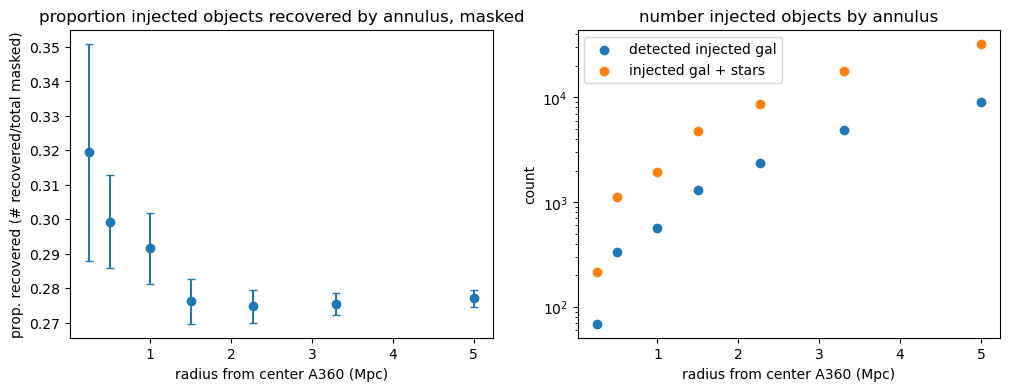

In [106]:
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
binsMpc = bins_mpc
binsdegrees = getBinsDegrees(binsMpc)

# get the surviving (numerator) 
alltable = Table.read("SSIRSRemovalTable.fits")
injectionWLCounts = getSampleDesired(alltable, binsdegrees)

# get the original catalog (no cuts) with the mask (denominator) 
maskedcatalog = Table.read("SSIMaskedCat.fits")
injectionCounts = getSampleDesired(maskedcatalog, binsdegrees)

# get the detection probability
detectionprob = injectionWLCounts/injectionCounts

# compute the uncertainity: success /total 
yerrs = []
for x in range(len(detectionprob)):
    binerr = computeWilsonCISingle(detectionprob[x], 0.68, injectionCounts[x])
    yerrs.append(binerr)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].errorbar(binsMpc[:len(detectionprob)], detectionprob, yerr=yerrs, fmt='o', capsize=3)
ax[0].set_title('proportion injected objects recovered by annulus, masked')
ax[0].set_xlabel('radius from center A360 (Mpc)')
ax[0].set_ylabel('prop. recovered (# recovered/total masked)')

ax[1].scatter(binsMpc[:len(injectionWLCounts)], injectionWLCounts, label='detected injected gal')
ax[1].scatter(binsMpc[:len(injectionWLCounts)], injectionCounts, label='injected gal + stars')
ax[1].set_title('number injected objects by annulus')
ax[1].set_xlabel('radius from center A360 (Mpc)')
ax[1].set_ylabel('count')
ax[1].set_yscale('log')
plt.legend()


demonstrates the proportion of objects recovered after all cuts. Proportion number of objects in sample / total amount of objects inj origianally (star+gal). Reflecting more recovered in earlier bins and fewer as a function of radius from the center of the cluster. On the right demonstrate the raw count of injected items to those recovered as a function of annulus. 

### compare the galaxy injected sample to the recovered sample

plot portion as function of annulus (# in final sample/total gal like injections) and compare to counts in annulus (# final, # initial)

In [107]:
def getExtendednessSample(catalog): 
    # take only those that are galaxy like or refExtendedness == 0.5 (as in WL_filt function)     
    extendedGalaxiesMask = catalog['refExtendedness'] == 1 
    extendedCatalog = catalog[extendedGalaxiesMask]

    return extendedCatalog

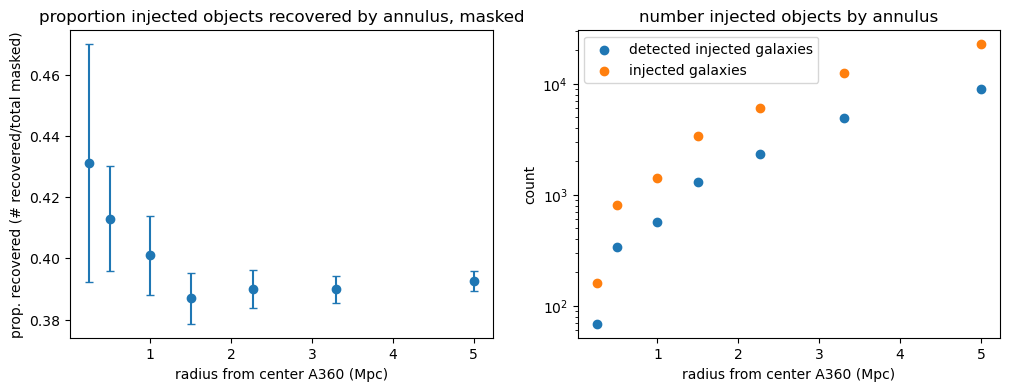

In [108]:
# get the surviving (numerator) 
alltable = Table.read("SSIRSRemovalTable.fits")
injectionWLCounts = getSampleDesired(alltable, binsdegrees)

# get the original catalog (no cuts) with the mask (denominator), first apply extendednesss 
maskedcatalog = Table.read("SSIMaskedCat.fits")
maskedcatalog = getExtendednessSample(maskedcatalog)
injectionCounts = getSampleDesired(maskedcatalog, binsdegrees)

# get the detection probability
detectionprob = injectionWLCounts/injectionCounts

# compute the uncertainity: success /total 
yerrs = []
for x in range(len(detectionprob)):
    binerr = computeWilsonCISingle(detectionprob[x], 0.68, injectionCounts[x])
    yerrs.append(binerr)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].errorbar(binsMpc[:len(detectionprob)], detectionprob, yerr=yerrs, fmt='o', capsize=3)
ax[0].set_title('proportion injected objects recovered by annulus, masked')
ax[0].set_xlabel('radius from center A360 (Mpc)')
ax[0].set_ylabel('prop. recovered (# recovered/total masked)')

ax[1].scatter(binsMpc[:len(injectionWLCounts)], injectionWLCounts, label='detected injected galaxies')
ax[1].scatter(binsMpc[:len(injectionWLCounts)], injectionCounts, label='injected galaxies')
ax[1].set_title('number injected objects by annulus')
ax[1].set_xlabel('radius from center A360 (Mpc)')
ax[1].set_ylabel('count')
ax[1].set_yscale('log')
plt.legend()

like above, but now filtering the denom to only include galaxies (on left). Increasing the proportion of recovered injections for all annuluar bins. On the right the raw count of injected galaxies to recovered. 

plot comparing the number of injected and "true" galaxies within the sample, with the count increasing as a function of radius from the center of the cluster

## Get the Density of objects 

### Compare the masked area by annulus 

examine BV masked area, with area persistent and proportion of that area kept

area kept computed by MC

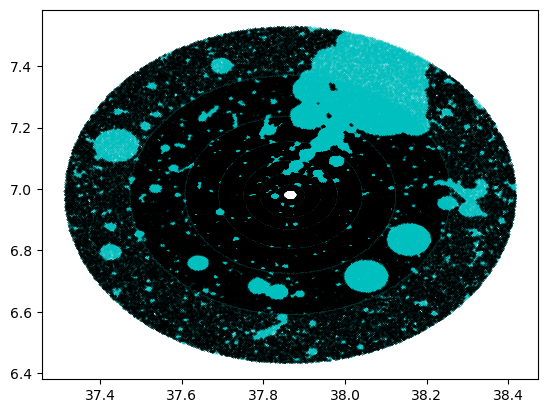

In [110]:
mask_hspbv15 ='/home/b/bclevine/A360/A360_full_mask_hsp_128_131072.parquet'

mask_hsp = hsp.HealSparseMap.read(mask_hspbv15)

# use standarized bins 
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
binsdegrees = getBinsDegrees(bins_mpc)

areas = []
proportions = []
for x in range(len(binsdegrees[:-1])):
    if x == 0: 
        effectiveareaarcmin, proportion = getUnmaskedArea(binsdegrees[x], binsdegrees[x+1], int(1e5), True)
        areas.append(effectiveareaarcmin)
        proportions.append(proportion)
    else: 
        effectiveareaarcmin, proportion = getUnmaskedArea(binsdegrees[x], binsdegrees[x+1], int(1e5), True)
        areas.append(effectiveareaarcmin)
        proportions.append(proportion)


recreation of the mask from Ben

In [111]:
errorbarlength = [] 
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])

for portion in proportions:
    errwidth = computeWilsonCISingle(portion, 0.68, int(1e5))
    errorbarlength.append(errwidth)
    #binerr = getBinomialStandardError(portion, int(1e5))

# get the geometric areas 
geometricareas = [] 
for x in range(len(binsdegrees)-1):
    radiusIn = binsdegrees[x]
    radiusOut = binsdegrees[x+1]
    geometricannulusarea = np.pi* (radiusOut**2) - np.pi * (radiusIn**2)
    # convert to arcmin **2
    areaannulusarcmin = geometricannulusarea * 3600
    geometricareas.append(areaannulusarcmin)

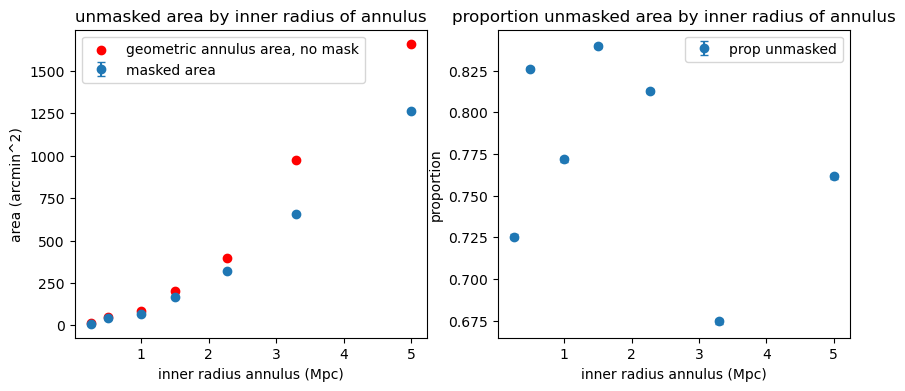

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(bins_mpc[:-1], geometricareas, label='geometric annulus area, no mask', color='red')
ax[0].errorbar(bins_mpc[:-1], areas, yerr=errorbarlength,  fmt='o', capsize=3, label='masked area')
ax[0].set_title("unmasked area by inner radius of annulus")
ax[0].set_ylabel("area (arcmin^2)")
ax[0].set_xlabel("inner radius annulus (Mpc)")
ax[0].legend()

ax[1].errorbar(bins_mpc[:-1], proportions, yerr=errorbarlength, fmt='o', capsize=3, label='prop unmasked')
ax[1].set_title("proportion unmasked area by inner radius of annulus")
ax[1].set_ylabel("proportion")
ax[1].set_xlabel("inner radius annulus (Mpc)")
ax[1].legend()

(left) plot confirming the relative areas of the annulus as a function of its inner radius. Both the geometric area (red) and the post-mask surviving area (blue). (Right) plot demonstrating the proportion of the annulus left unmasked as a function of the annulus' inner radius 

### Plot density of galaxies per annulus (real and injected)

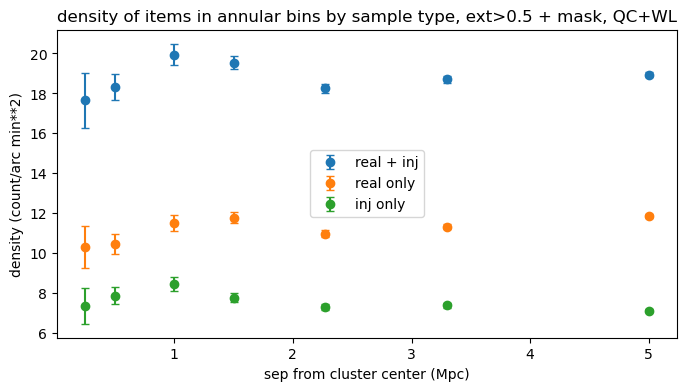

In [113]:
plotDensity(alltable, True, True, True, True)

Demonstrates distribution of galaxy like objects as a function of radius from the center of the cluster. Demonstrating the total amount injected into each annulus, and the amount recovered s the "true" galaxies in that region 

## Increase resolution (apply more bins)

### Extract how many each type galaxies survive cuts 

number in entire catalog 59268
number real 36537
number inject 22731


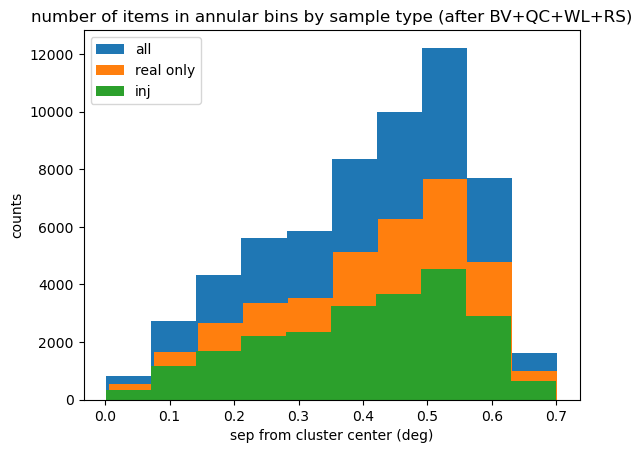

In [15]:
injectedmaskcolumn = data["ref_r_comp1_source_type"]
injectedmaskcolumnmask = injectedmaskcolumn.mask 
onlyNonInjectedObjects = data[injectedmaskcolumnmask]
inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
onlyInjectedObjects = data[inverseinjectedmaskcolumnmask]

print("number in entire catalog", len(data))
print("number real", len(onlyNonInjectedObjects))
print("number inject", len(onlyInjectedObjects))

plt.hist(data['sep'], label='all')
plt.hist(onlyNonInjectedObjects['sep'], label='real only')
plt.hist(onlyInjectedObjects['sep'], label='inj')
plt.title('number of items in annular bins by sample type (after BV+QC+WL+RS)')
plt.ylabel('counts')
plt.xlabel('sep from cluster center (deg)')
plt.legend()

### Raw - how many inj survive WL cuts by annular bin 

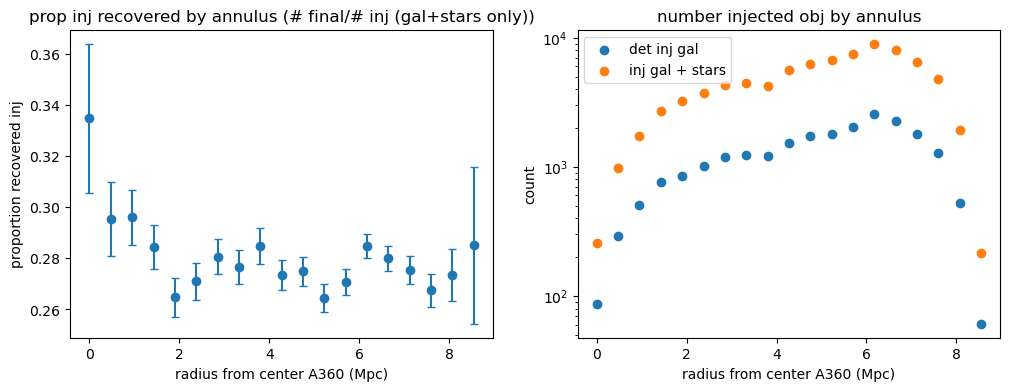

In [16]:
# even annulus widths 
binsMpc = clmm.make_bins(0, 9.5, nbins=20, method='evenwidth')

binsdegrees = getBinsDegrees(binsMpc)

# the number of galaxies in each bin left after cuts 
countscut, binscut = np.histogram(onlyInjectedObjects['sep'], bins = binsdegrees)

# want only things that are injected
injectedmaskcolumn = maskedcatalog["ref_r_comp1_source_type"]
injectedmaskcolumnmask = injectedmaskcolumn.mask 
inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
allOnlyInjectedObjects = maskedcatalog[inverseinjectedmaskcolumnmask]

# the number of galaxies in each bin originally injected 
countsoriginal, bins = np.histogram(allOnlyInjectedObjects['sep'], bins = binsdegrees)

# remove any zero bins from the end (allows for arbitrary ending of the bins) (from only the TOTAl injected)
countsoriginal = removeZeroBins(countsoriginal)

if len(countscut) != len(countsoriginal):
    countscut = countscut[:len(countsoriginal)]

# get the detection probability
detectionprob = countscut/countsoriginal

# compute the uncertainity - success /total 
yerrs = []
for x in range(len(detectionprob)):
    binerr = computeWilsonCISingle(detectionprob[x], 0.68, countsoriginal[x])
    yerrs.append(binerr)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].errorbar(binsMpc[:len(detectionprob)], detectionprob, yerr=yerrs, fmt='o', capsize=3)
ax[0].set_title('prop inj recovered by annulus (# final/# inj (gal+stars only))')
ax[0].set_xlabel('radius from center A360 (Mpc)')
ax[0].set_ylabel('proportion recovered inj')

ax[1].scatter(binsMpc[:len(countscut)], countscut, label='det inj gal')
ax[1].scatter(binsMpc[:len(countsoriginal)], countsoriginal, label='inj gal + stars')
ax[1].set_title('number injected obj by annulus')
ax[1].set_xlabel('radius from center A360 (Mpc)')
ax[1].set_ylabel('count')
ax[1].set_yscale('log')
plt.legend()

### compare just the galaxy injected sample to the recovered sample

[np.float64(0.03592836718500613), np.float64(0.01834257374895018), np.float64(0.013814137197653314), np.float64(0.011103415607888365), np.float64(0.010079697855833502), np.float64(0.009401851014041673), np.float64(0.008841546532372962), np.float64(0.00862509959483678), np.float64(0.008819507439690255), np.float64(0.0077431344284984), np.float64(0.0072820691407806835), np.float64(0.006999552747037382), np.float64(0.006656219863382405), np.float64(0.0061323874188235605), np.float64(0.006431383884986151), np.float64(0.007132949753582313), np.float64(0.008289327598504653), np.float64(0.013234228597218145), np.float64(0.04028207002926747)]


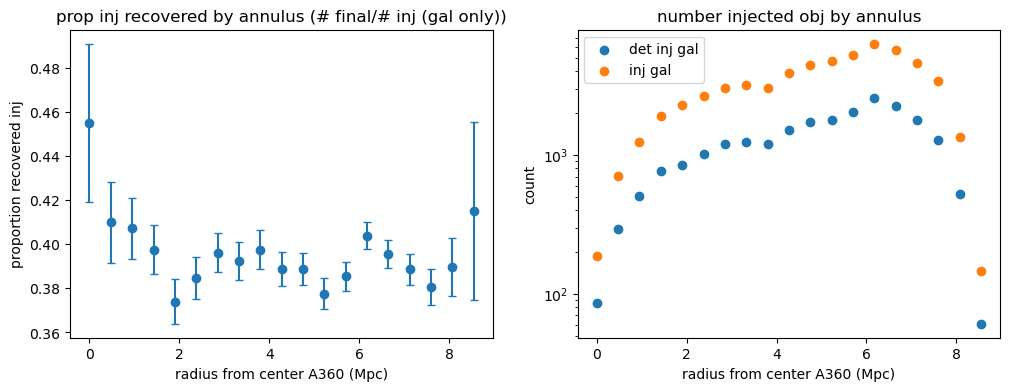

In [17]:
# get the original catalog (no cuts) with the mask
maskedcatalog = Table.read("SSIMaskedCat.fits")

binsMpc = clmm.make_bins(0, 9.5, nbins=20, method='evenwidth')
binsdegrees = getBinsDegrees(binsMpc)

# the number of galaxies in each bin left after cuts 
countscut, binscut = np.histogram(onlyInjectedObjects['sep'], bins = binsdegrees)

# want only things that are injected
injectedmaskcolumn = maskedcatalog["ref_r_comp1_source_type"]
injectedmaskcolumnmask = injectedmaskcolumn.mask 
inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
allOnlyInjectedObjects = maskedcatalog[inverseinjectedmaskcolumnmask]

# now take only those that are "gal" or refExtendedness == 1 
allOnlyInjectedGalaxiesMask = allOnlyInjectedObjects['refExtendedness'] == 1 
allOnlyInjectedGalaxies = allOnlyInjectedObjects[allOnlyInjectedGalaxiesMask]

# the number of galaxies in each bin originally injected 
countsoriginal, bins = np.histogram(allOnlyInjectedGalaxies['sep'], bins = binsdegrees)

# remove any zero bins from the end (allows for arbitrary ending of the bins) (from only the TOTAl injected)
countsoriginal = removeZeroBins(countsoriginal)

if len(countscut) != len(countsoriginal):
    countscut = countscut[:len(countsoriginal)]

# get the detection probability
detectionprob = countscut/countsoriginal

# compute the uncertainity 
yerrs = []
for x in range(len(detectionprob)):
    binerr = computeWilsonCISingle(detectionprob[x], 0.68, countsoriginal[x])
    yerrs.append(binerr)

print(yerrs)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].errorbar(binsMpc[:len(detectionprob)], detectionprob, yerr=yerrs, fmt='o', capsize=3)
ax[0].set_title('prop inj recovered by annulus (# final/# inj (gal only))')
ax[0].set_xlabel('radius from center A360 (Mpc)')
ax[0].set_ylabel('proportion recovered inj')

ax[1].scatter(binsMpc[:len(countscut)], countscut, label='det inj gal')
ax[1].scatter(binsMpc[:len(countsoriginal)], countsoriginal, label='inj gal')
ax[1].set_title('number injected obj by annulus')
ax[1].set_xlabel('radius from center A360 (Mpc)')
ax[1].set_ylabel('count')
ax[1].set_yscale('log')
plt.legend()

### Examine the input sample to recovered sample 

all inj galaxies is the number of galaxies injected into the field
det inj galaxies is the number of injected galaxies which survive WL/RS cuts
det real galaxies is the number NOT injected of galaxies which survive WL/RS cuts


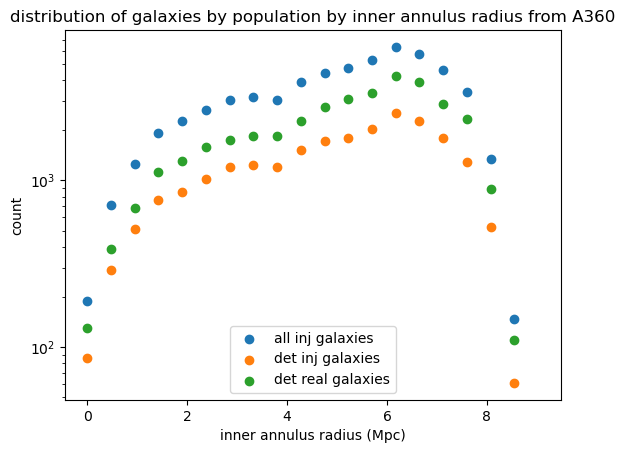

In [20]:
# use the bins used by the WL analysis and add the last bin 

binsMpc = clmm.make_bins(0, 9.5, nbins=20, method='evenwidth')
binsdegrees = getBinsDegrees(binsMpc)

# the number of galaxies in each bin left after cuts 
countscut, binscut = np.histogram(onlyInjectedObjects['sep'], bins = binsdegrees)

# want only things that are injected (but BV masked)
injectedmaskcolumn = maskedcatalog["ref_r_comp1_source_type"]
injectedmaskcolumnmask = injectedmaskcolumn.mask 
inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
allOnlyInjectedObjects = maskedcatalog[inverseinjectedmaskcolumnmask]
# now take only those that are "gal" or refExtendedness == 1 
allOnlyInjectedGalaxiesMask = allOnlyInjectedObjects['refExtendedness'] == 1 
allOnlyInjectedGalaxies = allOnlyInjectedObjects[allOnlyInjectedGalaxiesMask]

# the number of galaxies in each bin originally injected 
countsoriginal, bins = np.histogram(allOnlyInjectedGalaxies['sep'], bins = binsdegrees)

countsReal, bins = np.histogram(onlyNonInjectedObjects['sep'], bins = binsdegrees)

plt.scatter(binsMpc[:-1], countsoriginal, label='all inj galaxies')
plt.scatter(binsMpc[:-1], countscut, label='det inj galaxies')
plt.scatter(binsMpc[:-1], countsReal, label='det real galaxies')
plt.xlabel('inner annulus radius (Mpc)')
plt.ylabel('count')
plt.title('distribution of galaxies by population by inner annulus radius from A360')
plt.yscale('log')
plt.legend()

print("all inj galaxies is the number of galaxies injected into the field")
print("det inj galaxies is the number of injected galaxies which survive WL/RS cuts") 
print("det real galaxies is the number NOT injected of galaxies which survive WL/RS cuts")

### Compare to BV masked area by radius 

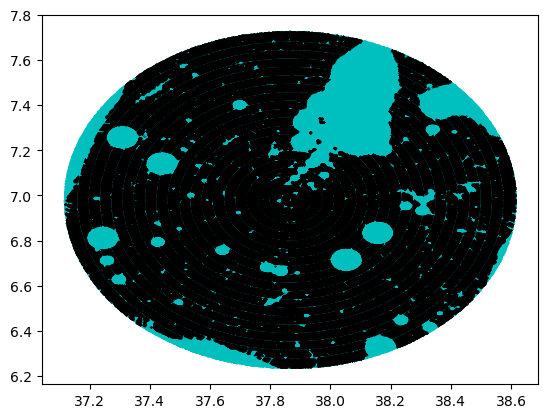

In [21]:
# use the bins used by the WL analysis and add the last bin 
binsMpc = clmm.make_bins(0, 9.5, nbins=20, method='evenwidth')
binsdegrees = getBinsDegrees(binsMpc)

areas = []
proportions = []
for x in range(len(binsdegrees[:-1])):
    if x == 0: 
        effectiveareaarcmin, proportion = getUnmaskedArea(0.01, binsdegrees[x+1], int(1e5), True)
        areas.append(effectiveareaarcmin)
        proportions.append(proportion)
    else: 
        effectiveareaarcmin, proportion = getUnmaskedArea(binsdegrees[x], binsdegrees[x+1], int(1e5), True)
        areas.append(effectiveareaarcmin)
        proportions.append(proportion)


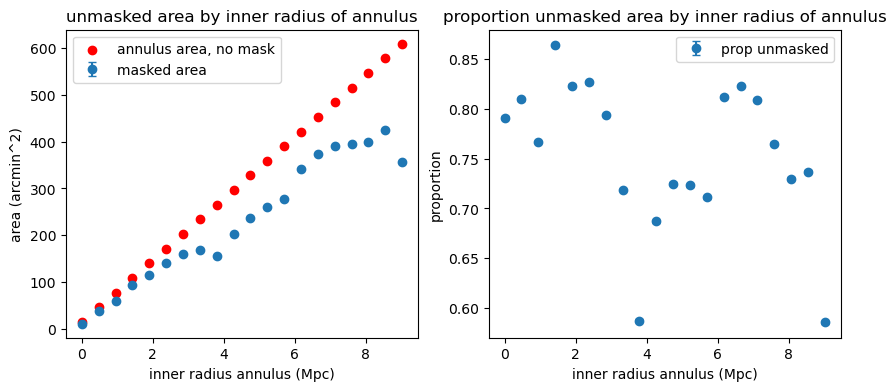

In [22]:
errorbarlength = [] 

for portion in proportions:
    errwidth = computeWilsonCISingle(portion, 0.68, int(1e5))
    errorbarlength.append(errwidth)

# get the geometric areas 
geometricareas = [] 
for x in range(len(binsdegrees)-1):
    radiusIn = binsdegrees[x]
    radiusOut = binsdegrees[x+1]
    geometricannulusarea = np.pi* (radiusOut**2) - np.pi * (radiusIn**2)
    # convert to arcmin **2
    areaannulusarcmin = geometricannulusarea * 3600
    geometricareas.append(areaannulusarcmin)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(binsMpc[:-1], geometricareas, label='annulus area, no mask', color='red')
ax[0].errorbar(binsMpc[:-1], areas, yerr=errorbarlength, fmt='o', capsize=3, label='masked area')
ax[0].set_title("unmasked area by inner radius of annulus")
ax[0].set_ylabel("area (arcmin^2)")
ax[0].set_xlabel("inner radius annulus (Mpc)")
ax[0].legend()

ax[1].errorbar(binsMpc[:-1], proportions, yerr=errorbarlength, fmt='o', capsize=3, label='prop unmasked')
ax[1].set_title("proportion unmasked area by inner radius of annulus")
ax[1].set_ylabel("proportion")
ax[1].set_xlabel("inner radius annulus (Mpc)")
ax[1].legend()

### Plot number of galaxies per annulus (real and injected)

all inj galaxies is the number of galaxies injected into the field
det inj galaxies is the number of injected galaxies which survive WL/RS cuts
det real galaxies is the number NOT injected of galaxies which survive WL/RS cuts


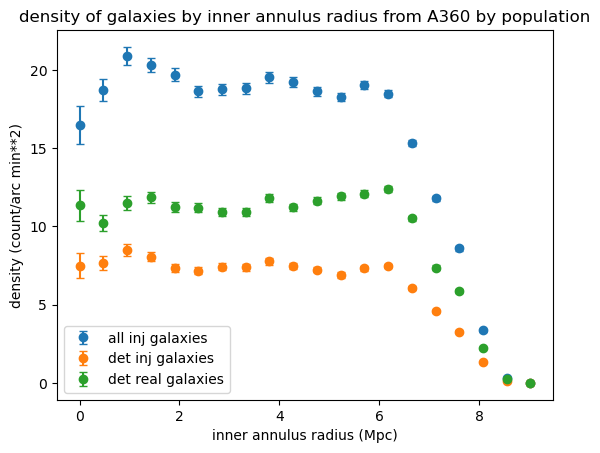

In [23]:
binsMpc = clmm.make_bins(0, 9.5, nbins=20, method='evenwidth')
binsdegrees = getBinsDegrees(binsMpc)

# the number of galaxies in each bin left after cuts 
countscut, binscut = np.histogram(onlyInjectedObjects['sep'], bins = binsdegrees)

# want only things that are injected (but BV masked)
injectedmaskcolumn = maskedcatalog["ref_r_comp1_source_type"]
injectedmaskcolumnmask = injectedmaskcolumn.mask 
inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
allOnlyInjectedObjects = maskedcatalog[inverseinjectedmaskcolumnmask]
# now take only those that are "gal" or refExtendedness == 1 
allOnlyInjectedGalaxiesMask = allOnlyInjectedObjects['refExtendedness'] == 1 
allOnlyInjectedGalaxies = allOnlyInjectedObjects[allOnlyInjectedGalaxiesMask]

# the number of galaxies in each bin originally injected 
countsoriginal, bins = np.histogram(allOnlyInjectedGalaxies['sep'], bins = binsdegrees)

# get real gal only 
countsReal, bins = np.histogram(onlyNonInjectedObjects['sep'], bins = binsdegrees)

# get the unceriatinities 
uncert0 = []
uncert1 = []
uncert2 = []
for x in range(len(proportions)): 
    uc0 = getDensityError(proportions[x], countscut[x], areas[x], int(1e5))
    uc1 = getDensityError(proportions[x], countsoriginal[x], areas[x], int(1e5))
    uc2 = getDensityError(proportions[x], countsReal[x], areas[x], int(1e5))
    uncert0.append(uc0)
    uncert1.append(uc1)
    uncert2.append(uc2)


plt.errorbar(binsMpc[:-1], countsoriginal/areas, yerr = uncert1, label='all inj galaxies', fmt='o', capsize=3)
plt.errorbar(binsMpc[:-1], countscut/areas, yerr=uncert0, label='det inj galaxies', fmt='o', capsize=3)
plt.errorbar(binsMpc[:-1], countsReal/areas, yerr = uncert2, label='det real galaxies', fmt='o', capsize=3)
plt.xlabel('inner annulus radius (Mpc)')
plt.ylabel('density (count/arc min**2)')
plt.title('density of galaxies by inner annulus radius from A360 by population')
plt.legend()

print("all inj galaxies is the number of galaxies injected into the field")
print("det inj galaxies is the number of injected galaxies which survive WL/RS cuts") 
print("det real galaxies is the number NOT injected of galaxies which survive WL/RS cuts")

## Apply more magntiude cuts 

### Limit the magntiude range examined as the proportion - abandonded

this was intially abandoned due to mistakes switching the two catalogs - but this is actually "fine" (to first order, there is bias in this)

In [12]:
# start by selecting BV surviving galaxies that are injected 

injectedmaskcolumn = maskedcatalog["ref_r_comp1_source_type"]
injectedmaskcolumnmask = injectedmaskcolumn.mask 
inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
allOnlyInjectedObjects = maskedcatalog[inverseinjectedmaskcolumnmask]
allOnlyInjectedGalaxiesMask = allOnlyInjectedObjects['refExtendedness'] == 1 
allOnlyInjectedGalaxies = allOnlyInjectedObjects[allOnlyInjectedGalaxiesMask]

# filter by i magnitude use i_cModel_mag  (NOT SURE THIS IS THE ONE BUT JSUT FOR NOW) 

# filter out the higher magnitude 
injectGalaxiesAllMagFilterlower = allOnlyInjectedGalaxies['i_cModel_mag'] < 23.73
injectGalLimitMaglower = allOnlyInjectedGalaxies[injectGalaxiesAllMagFilterlower]

# filter out the lower magnitude 
injectGalaxiesAllMagFilterhigher = injectGalLimitMaglower['i_cModel_mag'] > 20
injectGalLimitMagBoth = injectGalLimitMaglower[injectGalaxiesAllMagFilterhigher]

print("the number of inj galaxies w i_cModle_mag in 20-23.76 is (no cuts)", len(injectGalLimitMagBoth))
print("the number or inj (wl cut surviving) galaxies in the range is", len(allOnlyInjectedGalaxies))

# start by selecting BV surviving galaxies that are injected 

injectedmaskcolumn = maskedcatalog["ref_r_comp1_source_type"]
injectedmaskcolumnmask = injectedmaskcolumn.mask 
inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
allOnlyInjectedObjects = maskedcatalog[inverseinjectedmaskcolumnmask]
allOnlyInjectedGalaxiesMask = allOnlyInjectedObjects['refExtendedness'] == 1 
allOnlyInjectedGalaxies = allOnlyInjectedObjects[allOnlyInjectedGalaxiesMask]

# filter by i magnitude use i_cModel_mag  (NOT SURE THIS IS THE ONE BUT JSUT FOR NOW) 

# filter out the higher magnitude 
injectGalaxiesAllMagFilterlower = allOnlyInjectedGalaxies['i_gaap_mag'] < 23.73
injectGalLimitMaglower = allOnlyInjectedGalaxies[injectGalaxiesAllMagFilterlower]

# filter out the lower magnitude 
injectGalaxiesAllMagFilterhigher = injectGalLimitMaglower['i_gaap_mag'] > 20
injectGalLimitMagBoth = injectGalLimitMaglower[injectGalaxiesAllMagFilterhigher]

print("the number of inj galaxies w i_gaap_mag in 20-23.76 is (no cuts)", len(injectGalLimitMagBoth))
print("the number or inj (wl cut surviving) galaxies in the range is", len(allOnlyInjectedGalaxies))

the number of inj galaxies w i_cModle_mag in 20-23.76 is (no cuts) 25550
the number or inj (wl cut surviving) galaxies in the range is 58154
the number of inj galaxies w i_gaap_mag in 20-23.76 is (no cuts) 22694
the number or inj (wl cut surviving) galaxies in the range is 58154


this means that you cant use this as a discriminator 

1.21.26: but this is actually not the right outcome. You switched the catalogs when you were printing the occupancy and did not notice it when you initially ran this, leading you to abandon this. But in reality we can filter over these. 

### examine 2 catalogs (pre and post cuts) 

In [114]:
def separateCatalog(catalog, listvalues):
    # filter for injection, find real objects 
    injectedmaskcolumn = catalog["ref_r_comp1_source_type"]
    injectedmaskcolumnmask = injectedmaskcolumn.mask 
    nonInjectedObjects = catalog[injectedmaskcolumnmask]

    # take the inverse to get injected objects 
    inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
    injectedObjects = catalog[inverseinjectedmaskcolumnmask]

    if listvalues:
        print("number obj in entire catalog:", len(catalog))
        print("number real obj:", len(nonInjectedObjects))
        print("number inject obj:", len(injectedObjects))
        print("")

    return nonInjectedObjects, injectedObjects

In [123]:
# get the original catalog (no cuts), mask applied 
maskedcatalog = Table.read("SSIMaskedCat.fits")
originalNotInjected, originalInjected = separateCatalog(maskedcatalog, True)

# all selection cuts table
alltable = Table.read("SSIRSRemovalTable.fits")
notInjected, injected = separateCatalog(alltable, True)

number obj in entire catalog: 1074586
number real obj: 156056
number inject obj: 918530

number obj in entire catalog: 59268
number real obj: 36537
number inject obj: 22731



number in entire catalog 59268
number real 36537
number inject 22731


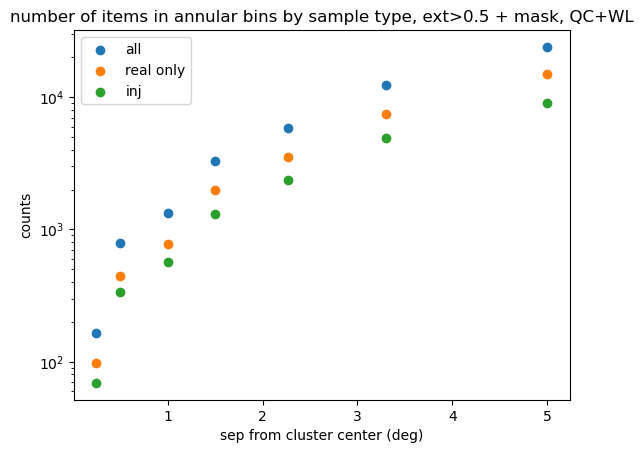

In [127]:
plotOccupany(alltable, True, True, True, True)

number in entire catalog 1074586
number real 156056
number inject 918530


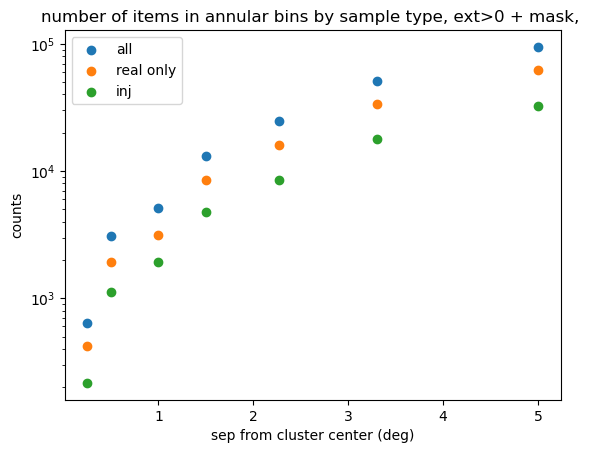

In [126]:
plotOccupany(maskedcatalog, False, True, True, False)

/tmp/ipykernel_3839/2141463639.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set_ylim(0,100000)
/tmp/ipykernel_3839/2141463639.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[1].set_ylim(0,100000)


(np.float64(185.9873141227024), 100000)

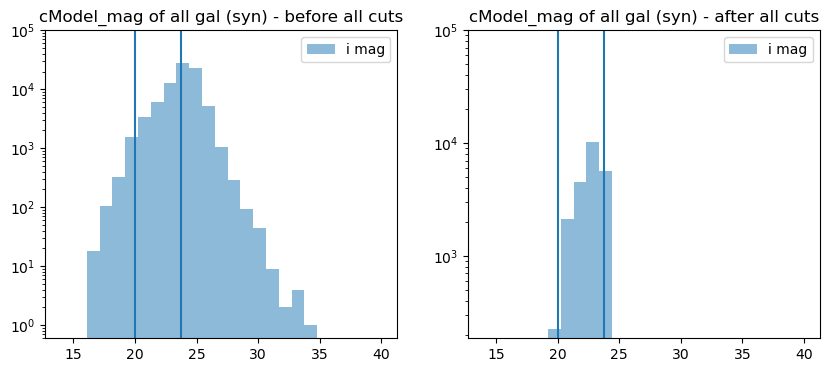

In [128]:
usebins = np.linspace(14, 40, 26)  # 29 bins

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#ax[0].hist(originalInjected["g_cModel_mag"], bins = usebins, label='g mag', alpha=0.5)
#ax[0].hist(originalInjected["r_cModel_mag"], bins = usebins, label='r mag', alpha=0.5)
ax[0].hist(originalInjected["i_cModel_mag"], bins = usebins, label='i mag', alpha=0.5)
#ax[0].hist(originalInjected["z_cModel_mag"], bins = usebins, label='z mag', alpha=0.5)
ax[0].axvline(x=20, ymin=0, ymax=1e4)
ax[0].axvline(x=23.76, ymin=0, ymax=1e4)
ax[0].legend()
ax[0].set_title("cModel_mag of all gal (syn) - before all cuts")
ax[0].set_yscale('log')
ax[0].set_ylim(0,100000)

#ax[1].hist(injected["g_cModel_mag"], bins = usebins, label='g mag', alpha=0.5)
#ax[1].hist(injected["r_cModel_mag"], bins = usebins, label='r mag', alpha=0.5)
ax[1].hist(injected["i_cModel_mag"], bins = usebins, label='i mag', alpha=0.5)
#ax[1].hist(injected["z_cModel_mag"], bins = usebins, label='z mag', alpha=0.5)
ax[1].axvline(x=20, ymin=0, ymax=1e4)
ax[1].axvline(x=23.76, ymin=0, ymax=1e4)
ax[1].legend()
ax[1].set_title("cModel_mag of all gal (syn) - after all cuts")
ax[1].set_yscale('log')
ax[1].set_ylim(0,100000)

## verify the magnitude range and extendedness of the sample

In [129]:
def verifyWLGalaxyCatalog(catalog, listvalues):
    # filter by the upper end of the mag range 
    lower = catalog["i_cModel_mag"]> 20
    upperSubCatalog = catalog[lower]

    # filter by the lower end of the mag range 
    upper = upperSubCatalog["i_cModel_mag"]< 23.76
    subCatalog = upperSubCatalog[upper]

    # filter by extendedness 
    extended = subCatalog['refExtendedness'] >= 0.5
    newcatalog = subCatalog[extended]

    if listvalues:
        print("# obj in catalog:", len(catalog))

        print("# obj in the WL mag range:", len(subCatalog))

        print("# extended obj in WL mag range:", len(newcatalog))

        print("extendedness removes:", len(subCatalog)-len(newcatalog))
        
        print("")

    return newcatalog

In [130]:
maskedcatalog = Table.read("SSIMaskedCat.fits")

In [131]:
# separate the catalog into 2 part 
# originalNotInjected, originalInjected = separateCatalog(maskedcatalog, True)

# verify WL/extendedness cuts 
originalAllWL = verifyWLGalaxyCatalog(maskedcatalog, True)
originalInjectedWL = verifyWLGalaxyCatalog(originalInjected, True)
originalNonInjectedWL = verifyWLGalaxyCatalog(originalNotInjected, True)

# obj in catalog: 1074586
# obj in the WL mag range: 80850
# extended obj in WL mag range: 69862
extendedness removes: 10988

# obj in catalog: 918530
# obj in the WL mag range: 30592
# extended obj in WL mag range: 26138
extendedness removes: 4454

# obj in catalog: 156056
# obj in the WL mag range: 50258
# extended obj in WL mag range: 43724
extendedness removes: 6534



In [132]:
# separate the catalog into 2 part 
# notInjected, injected = separateCatalog(alltable, True)

# verify WL/extendedness cuts 
allWL = verifyWLGalaxyCatalog(alltable, True)
injectedWL = verifyWLGalaxyCatalog(injected, True)
nonInjectedWL = verifyWLGalaxyCatalog(notInjected, True)

# obj in catalog: 59268
# obj in the WL mag range: 59268
# extended obj in WL mag range: 59268
extendedness removes: 0

# obj in catalog: 22731
# obj in the WL mag range: 22731
# extended obj in WL mag range: 22731
extendedness removes: 0

# obj in catalog: 36537
# obj in the WL mag range: 36537
# extended obj in WL mag range: 36537
extendedness removes: 0



In [138]:
def plotMag(rbool, gbool, ibool, originalInjectedWL, injectedWL):
    usebins = np.linspace(14, 40, 26)  # 29 bins
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    plt.suptitle("A360 magntiude injected sources, refext >=0.5, i mag 20-23.76")
    
    ax[0].hist(originalInjectedWL["i_cModel_mag"], bins = usebins, label='i mag', alpha=0.5)
    ax[0].axvline(x=20, ymin=0, ymax=1e4)
    ax[0].axvline(x=23.76, ymin=0, ymax=1e4)
    ax[0].legend()
    ax[0].set_title("cModel_mag of all gal (syn) - before all cuts")
    ax[0].set_yscale('log')
    ax[0].set_ylim(0,20000)
    
    ax[1].hist(injectedWL["i_cModel_mag"], bins = usebins, label='i mag', alpha=0.5)
    ax[1].axvline(x=20, ymin=0, ymax=1e4)
    ax[1].axvline(x=23.76, ymin=0, ymax=1e4)
    ax[1].legend()
    ax[1].set_title("cModel_mag of all gal (syn) - after all cuts")
    ax[1].set_yscale('log')
    ax[1].set_ylim(0,20000)

    if gbool: 
        ax[0].hist(originalInjectedWL["g_cModel_mag"], bins = usebins, label='g mag', alpha=0.5)
        ax[1].hist(injectedWL["g_cModel_mag"], bins = usebins, label='g mag', alpha=0.5)

    if rbool: 
        ax[0].hist(originalInjectedWL["r_cModel_mag"], bins = usebins, label='r mag', alpha=0.5)
        ax[1].hist(injectedWL["r_cModel_mag"], bins = usebins, label='r mag', alpha=0.5)

    if ibool: 
        ax[0].hist(originalInjectedWL["z_cModel_mag"], bins = usebins, label='z mag', alpha=0.5)
        ax[1].hist(injectedWL["z_cModel_mag"], bins = usebins, label='z mag', alpha=0.5)


/tmp/ipykernel_3839/3919697046.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set_ylim(0,20000)
/tmp/ipykernel_3839/3919697046.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[1].set_ylim(0,20000)


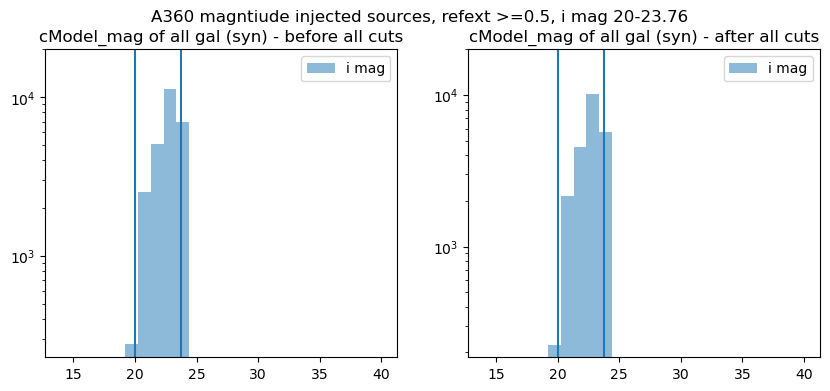

In [139]:
plotMag(False, False, False, originalInjectedWL, injectedWL)

(38.8, 37.0)

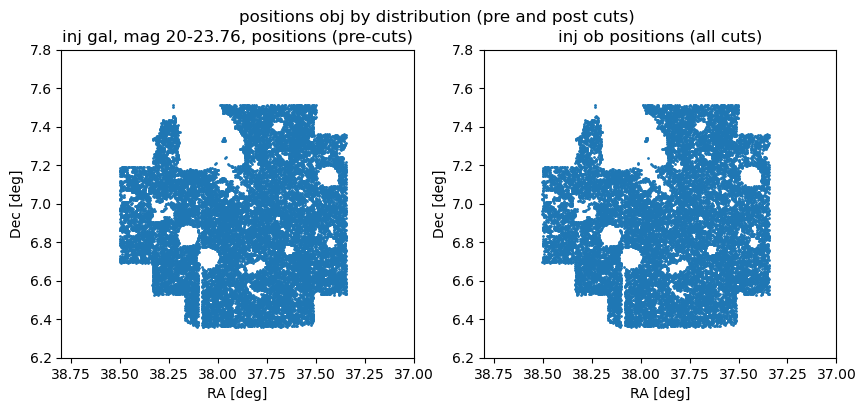

<Figure size 640x480 with 0 Axes>

In [141]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("positions obj by distribution (pre and post cuts)")

plt.figure()
ax[0].scatter(originalInjectedWL['coord_ra'], originalInjectedWL['coord_dec'], s=1)
ax[0].set_xlabel("RA [deg]")
ax[0].set_ylabel("Dec [deg]")
ax[0].set_title("inj gal, mag 20-23.76, positions (pre-cuts)")
ax[0].set_ylim(6.2, 7.8)
ax[0].set_xlim(38.8, 37)

ax[1].scatter(injectedWL['coord_ra'], injectedWL['coord_dec'], s=1)
ax[1].set_xlabel("RA [deg]")
ax[1].set_ylabel("Dec [deg]")
ax[1].set_title("inj ob positions (all cuts)")
ax[1].set_ylim(6.2, 7.8)
ax[1].set_xlim(38.8, 37)


the left plot has extendedness >=0.5 and mag i 20-23.76. Right plot has all cuts. 

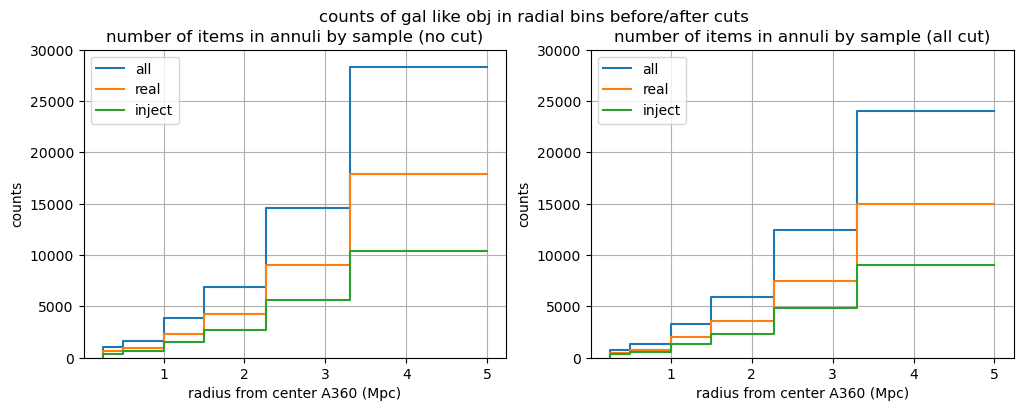

In [13]:
# plot the distribution before all the cuts (left) 

# separate the catalog into 2 part 
# originalNotInjected, originalInjected = separateCatalog(maskedcatalog, True)

originalentirecounts, bins = np.histogram(originalAllWL['sep'], bins = binsdegrees)
originalrealcounts, bins = np.histogram(originalNonInjectedWL['sep'], bins = binsdegrees)
originalinjectedcounts, bins = np.histogram(originalInjectedWL['sep'], bins = binsdegrees)

# plot the distribution after all the cuts (right) 

entirecounts, bins = np.histogram(allWL['sep'], bins = binsdegrees)
realcounts, bins = np.histogram(nonInjectedWL['sep'], bins = binsdegrees)
injectedcounts, bins = np.histogram(injectedWL['sep'], bins = binsdegrees)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("counts of gal like obj in radial bins before/after cuts")

ax[0].step(bins_mpc[:-1], originalentirecounts, label='all')
ax[0].step(bins_mpc[:-1], originalrealcounts, label='real')
ax[0].step(bins_mpc[:-1], originalinjectedcounts, label='inject')
ax[0].set_title('number of items in annuli by sample (no cut)')
ax[0].set_ylabel('counts')
ax[0].set_xlabel('radius from center A360 (Mpc)')
ax[0].set_ylim(0, 30000)
ax[0].legend()
ax[0].grid()

ax[1].step(bins_mpc[:-1], entirecounts, label='all')
ax[1].step(bins_mpc[:-1], realcounts, label='real')
ax[1].step(bins_mpc[:-1], injectedcounts, label='inject')
ax[1].set_title('number of items in annuli by sample (all cut)')
ax[1].set_ylabel('counts')
ax[1].set_xlabel('radius from center A360 (Mpc)')
ax[1].set_ylim(0, 30000)
ax[1].legend()
ax[1].grid()

## compare recovered to initial sample

In [142]:
originalentirecounts, bins = np.histogram(originalAllWL['sep'], bins = binsdegrees)
originalrealcounts, bins = np.histogram(originalNonInjectedWL['sep'], bins = binsdegrees)
originalinjectedcounts, bins = np.histogram(originalInjectedWL['sep'], bins = binsdegrees)

# plot the distribution after all the cuts (right) 

entirecounts, bins = np.histogram(allWL['sep'], bins = binsdegrees)
realcounts, bins = np.histogram(nonInjectedWL['sep'], bins = binsdegrees)
injectedcounts, bins = np.histogram(injectedWL['sep'], bins = binsdegrees)

proportionAll = entirecounts/ originalentirecounts
proportionReal = realcounts/originalrealcounts
proportionInjected = injectedcounts/originalinjectedcounts

allerrs = []
realerrs = []
injerrs = [] 
for x in range(len(proportionAll)):
    allerr = computeWilsonCISingle(proportionAll[x], 0.68, originalentirecounts[x])
    allerrs.append(allerr)
    
    reallerr = computeWilsonCISingle(proportionReal[x], 0.68, originalrealcounts[x])
    realerrs.append(reallerr)
    
    injerr = computeWilsonCISingle(proportionInjected[x], 0.68, originalinjectedcounts[x])
    injerrs.append(injerr)

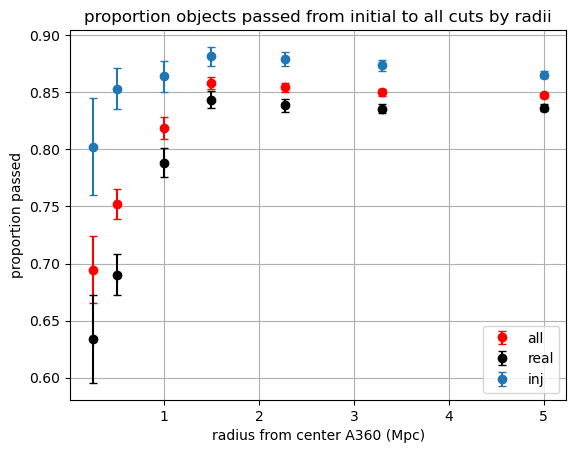

In [143]:
# even annulus widths 
binsMpc = bins_mpc
binsdegrees = getBinsDegrees(binsMpc)

plt.errorbar(binsMpc[:-1], proportionAll, label='all', yerr=allerrs, fmt='o', capsize=3, color='red')
plt.errorbar(binsMpc[:-1], proportionReal, label='real', yerr=realerrs, fmt='o', capsize=3, color='black')
plt.errorbar(binsMpc[:-1], proportionInjected, label='inj', yerr=injerrs, fmt='o', capsize=3, color='C0')
plt.ylabel("proportion passed")
plt.xlabel("radius from center A360 (Mpc)")
plt.title("proportion objects passed from initial to all cuts by radii")
plt.grid()
plt.legend()

in detail: the above demonstrates the amount [# objects in the final sample (after all cuts)]/ [# objects in the original sample in the mag range and with extendedness desired] 

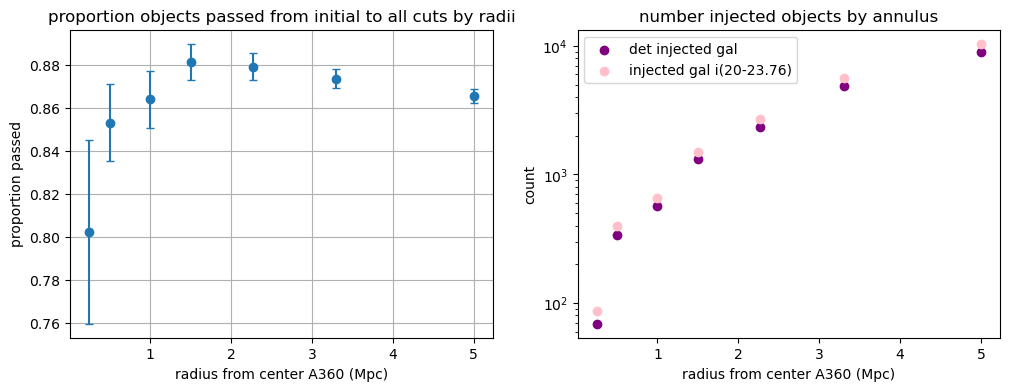

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].errorbar(binsMpc[:-1], proportionInjected, label='inj', yerr=injerrs, fmt='o', capsize=3)
ax[0].set_ylabel("proportion passed")
ax[0].set_xlabel("radius from center A360 (Mpc)")
ax[0].set_title("proportion objects passed from initial to all cuts by radii")
ax[0].grid()

ax[1].scatter(binsMpc[:len(injectedcounts)], injectedcounts, label='det injected gal', color='purple')
ax[1].scatter(binsMpc[:len(originalinjectedcounts)], originalinjectedcounts, label='injected gal i(20-23.76)', color='pink')
ax[1].set_title('number injected objects by annulus')
ax[1].set_xlabel('radius from center A360 (Mpc)')
ax[1].set_ylabel('count')
ax[1].set_yscale('log')
plt.legend()


In [145]:
# check if there are things in the WL sample (purple) that aren't in the initial sample (pink)

allInjectSampleIDs = originalInjectedWL['objectId']
wlInjectSampleIDs = injectedWL['objectId']

for number in wlInjectSampleIDs:
    if number not in allInjectSampleIDs:
        print(number)

print('task finished')

task finished


## plot the density for the recovered injected sources

initial problem: the field not exactly that from the mask, some portions are missing for outter annuli (due to 3/4 tracks present)


solution: need to MC simulate the field that is in the initial SSI catalog 


### Get the area - in progress

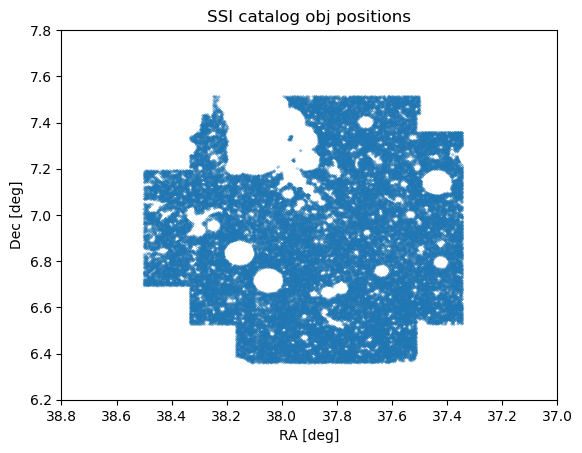

In [15]:
# want to plot the original sample - no cuts, just the mask applied. 

maskedcatalog = Table.read("SSIMaskedCat.fits")

plt.figure()
plt.scatter(maskedcatalog['coord_ra'], maskedcatalog['coord_dec'], s=0.01)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("SSI catalog obj positions")
plt.ylim(6.2, 7.8)
plt.xlim(38.8, 37)
plt.show()


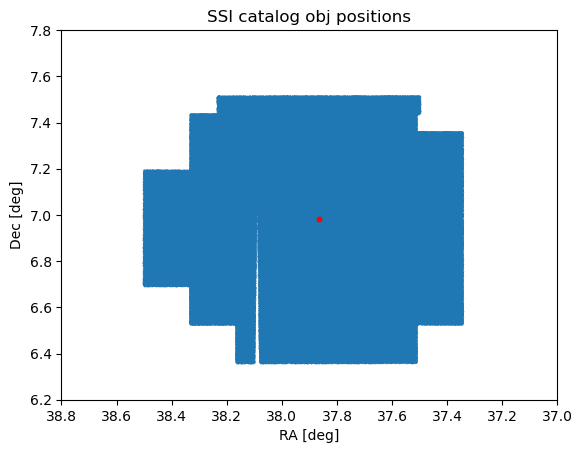

In [16]:
# want to plot the original sample - no cuts, just the mask applied. 

ra_bcg = 37.86501659859067
dec_bcg = 6.982204815599694

maskedcatalog = Table.read("SSIMaskedCat.fits")

plt.figure()
plt.scatter(maskedcatalog['ref_ra'], maskedcatalog['ref_dec'], s=0.01)
plt.scatter(ra_bcg, dec_bcg, s=10, color='red')
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("SSI catalog obj positions")
plt.ylim(6.2, 7.8)
plt.xlim(38.8, 37)
plt.show()


In [17]:
def getCustomArea(catalog, radiusIn, radiusOut, numberobjects):
    # cluster coordinates
    ra_bcg = 37.86501659859067
    dec_bcg = 6.982204815599694

    circlemap = hsp.HealSparseMap.make_empty(32, 32768, np.uint16)

    # the outer radius 
    circlemap |= hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=radiusOut, value=1)
    # the inner radius 
    circlemap &= hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=radiusIn, value=0)

    ra_rand, dec_rand = hsp.make_uniform_randoms_fast(circlemap, numberobjects)

    for x in range(len(ra_rand)):
        pt = (ra_rand[x], dec_rand[x])
        
    
    plt.scatter(catalog['coord_ra'], catalog['coord_dec'], s=0.1, label='obj detected')
    plt.scatter(ra_bcg, dec_bcg, s=10, color='red')

    plt.scatter(ra_rand, dec_rand, marker='.', s=10, color='black', label='rng')
    plt.xlabel("RA [deg]")
    plt.ylabel("Dec [deg]")

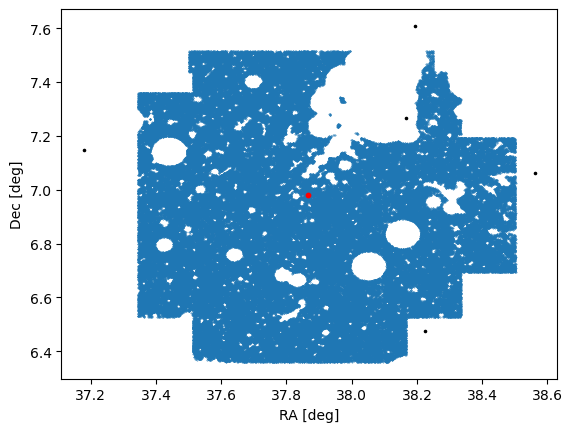

In [18]:
getCustomArea(maskedcatalog, 0.01, 0.75, 5)

In [19]:
def findTheEdges(catalog): 
    absolutemindec = catalog['ref_dec'].min()
    absolutemaxdec = catalog['ref_dec'].max()
    
    absoluteminra = catalog['ref_ra'].min()
    absolutemaxra = catalog['ref_ra'].max()

    return absolutemindec, absolutemaxdec, absoluteminra, absolutemaxra
    
def searchSubregion(catalog, ratarget, dectarget): 
    smalldec = catalog['ref_dec'].min()
    bigdec = catalog['ref_dec'].max()
    
    absoluteminra = catalog['ref_ra'].min()
    absolutemaxra = catalog['ref_ra'].max()

    return subRA, subDec

def searchSpecificLL(catalog, ra, dec):
    # first find the RA 
    # want the RA to the right of the value given (larger)
    maskRA = catalog['ref_ra'] > ra
    subcatRA = catalog[maskRA]

    # want the dec below the given value (smaller) 
    maskdec = subcatRA['ref_dec'] < dec 
    subcat = subcatRA[maskdec]

    desiredra = subcat['ref_ra'].min()

    # second find the Dec 
    # want the ra below the value (smaller) 
    maskRA = catalog['ref_ra'] < ra
    subcatRA = catalog[maskRA]

    # want the dec above the given value (larger) 
    maskdec = subcatRA['ref_dec'] > dec 
    subcat = subcatRA[maskdec]
    
    desireddec = subcat['ref_dec'].min()


    return desireddec, desiredra

def searchSpecificLR(catalog, ra, dec):
    # first find the RA 
    # want the RA to the left of the value given (smaller)
    maskRA = catalog['ref_ra'] < ra
    subcatRA = catalog[maskRA]

    # want the dec below the given value (smaller) 
    maskdec = subcatRA['ref_dec'] < dec 
    subcat = subcatRA[maskdec]

    desiredra = subcat['ref_ra'].max()

    # # second find the Dec 
    # want the ra below the value (smaller) 
    maskRA = catalog['ref_ra'] > ra
    subcatRA = catalog[maskRA]

    # want the dec above the given value (larger) 
    maskdec = subcatRA['ref_dec'] > dec 
    subcat = subcatRA[maskdec]
    
    desireddec = subcat['ref_dec'].min()

    # plt.scatter(subcat['ref_ra'], subcat['ref_dec'], s=0.1, alpha=0.5)
    # plt.xlabel("RA [deg]")
    # plt.ylabel("Dec [deg]")

    return desireddec, desiredra

def searchSpecificUR(catalog, ra, dec):
    # first find the RA 
    # want the RA to the left of the value given (smaller)
    maskRA = catalog['ref_ra'] < ra
    subcatRA = catalog[maskRA]

    # want the dec below the given value (smaller) 
    maskdec = subcatRA['ref_dec'] > dec 
    subcat = subcatRA[maskdec]

    desiredra = subcat['ref_ra'].max()

    # print(desiredra)
    # # second find the Dec 
    # want the ra below the value (smaller) 
    maskRA = catalog['ref_ra'] > ra
    subcatRA = catalog[maskRA]

    # want the dec above the given value (larger) 
    maskdec = subcatRA['ref_dec'] < dec 
    subcat = subcatRA[maskdec]
    
    desireddec = subcat['ref_dec'].max()

    # print(desireddec)

    # plt.scatter(subcat['ref_ra'], subcat['ref_dec'], s=0.1, alpha=0.5)
    # plt.xlabel("RA [deg]")
    # plt.ylabel("Dec [deg]")

    return desireddec, desiredra

def searchSpecificUL(catalog, ra, dec):
    # first find the RA 
    # want the RA to the left of the value given (smaller)
    maskRA = catalog['ref_ra'] > ra
    subcatRA = catalog[maskRA]

    # want the dec below the given value (smaller) 
    maskdec = subcatRA['ref_dec'] > dec 
    subcat = subcatRA[maskdec]

    desiredra = subcat['ref_ra'].min()

    # print(desiredra)
    # # second find the Dec 
    # want the ra below the value (smaller) 
    maskRA = catalog['ref_ra'] < ra
    subcatRA = catalog[maskRA]

    # want the dec above the given value (larger) 
    maskdec = subcatRA['ref_dec'] < dec 
    subcat = subcatRA[maskdec]
    
    desireddec = subcat['ref_dec'].max()

    return desireddec, desiredra

def searchSpecificCUSTOM(catalog, ra, dec, decmin, ramin):
    catNewMask = decmin < catalog['ref_dec'] 
    DECcatalog = catalog[catNewMask]

    raMask = ramin < DECcatalog['ref_ra'] 
    racat = DECcatalog[raMask]
    ramask2 = racat['ref_ra'] < ra
    racat = racat[ramask2]
    
    desireddec = racat['ref_dec'].min()

    decmask2 = catalog['ref_dec'] > decmin 
    racat2 = catalog[decmask2]

    decmask3 = racat2['ref_dec'] < desireddec
    racatalog = racat2[decmask3]

    ramask2 = racatalog['ref_ra'] > ra
    racatalogFULL = racatalog[ramask2]
    
    desiredra = racatalogFULL['ref_ra'].min()
    
    return desireddec, desiredra

37.50681322840396


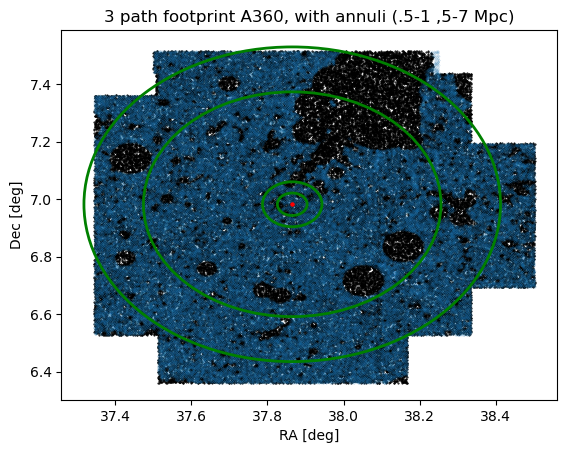

In [51]:
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
binsMpc = bins_mpc
binsdegrees = getBinsDegrees(binsMpc)


ra_bcg = 37.86501659859067
dec_bcg = 6.982204815599694

numberobjects = int(1e5)

# first have the baseline square 
absolutemindec, absolutemaxdec, absoluteminra, absolutemaxra = findTheEdges(maskedcatalog)
poly = hsp.HealSparseMap.make_empty(32, 32768, np.uint16)
poly |= hsp.Polygon(ra=[absoluteminra, absoluteminra, absolutemaxra, absolutemaxra],
                    dec=[absolutemindec, absolutemaxdec, absolutemaxdec, absolutemindec],
                          value=1)

desireddec, desiredra = searchSpecificLL(maskedcatalog, 37.4, 6.5)
poly &= hsp.Polygon(ra=[absoluteminra, absoluteminra, desiredra, desiredra],
                    dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                          value=0)

# remove the LR (in 2 parts) 
# first remove the leftmost 
desireddec, desiredra = searchSpecificLR(maskedcatalog, 38.2, 6.45)
poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                    dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                          value=0)

# now remove the right part 
desireddec, desiredra = searchSpecificLR(maskedcatalog, 38.4, 6.6)
poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                    dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                          value=0)

# remove the UR (in 2 parts) 
desireddec, desiredra = searchSpecificUR(maskedcatalog, 38.4, 7.3)
poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                    dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                          value=0)

# second upper part 
desireddec, desiredra = searchSpecificUR(maskedcatalog, 38.3, 7.45)
poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                    dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                          value=0)


# remove UL (in 2 parts) 
desireddec, desiredra = searchSpecificUL(maskedcatalog, 37.4, 7.4)
poly &= hsp.Polygon(ra=[desiredra, desiredra, absoluteminra, absoluteminra],
                    dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                          value=0)

ptRA = desiredra+0.005
ptDEC = desireddec+0.02

desireddecprime, desiredraprime = searchSpecificCUSTOM(maskedcatalog, ptRA, ptDEC, desireddec, desiredra)
poly &= hsp.Polygon(ra=[desiredraprime, desiredraprime, desiredra, desiredra],
                    dec=[desireddec, desireddecprime, desireddecprime, desireddec],
                          value=0)

ra_rand, dec_rand = hsp.make_uniform_randoms_fast(poly, numberobjects)

fig, ax = plt.subplots()

plt.scatter(ra_rand, dec_rand, marker='.', s=1, color='black', label='rng')
plt.scatter(maskedcatalog['coord_ra'], maskedcatalog['coord_dec'], s=0.01, label='obj detected', alpha=0.5)
plt.scatter(ra_bcg, dec_bcg, s=5, color='red')
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("3 path footprint A360, with annuli (.5-1 ,5-7 Mpc)")

circle2 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[1], color='green', fill=False, linewidth=2)
circle3 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[2], color='green', fill=False, linewidth=2)
circle4 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[-2], color='green', fill=False, linewidth=2)
circle5 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[-1], color='green', fill=False, linewidth=2)

ax.add_patch(circle3)
ax.add_patch(circle2)
ax.add_patch(circle4)
ax.add_patch(circle5)

In [20]:
mask_hspbv15 ='/home/b/bclevine/A360/A360_full_mask_hsp_128_131072.parquet'

mask_hsp = hsp.HealSparseMap.read(mask_hspbv15)

37.50681322840396


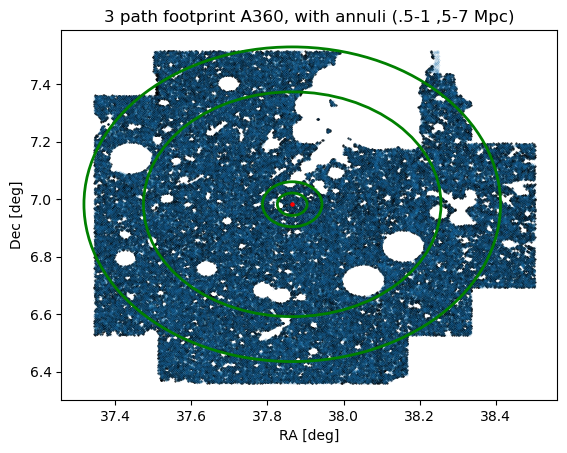

In [55]:

bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
binsMpc = bins_mpc
binsdegrees = getBinsDegrees(binsMpc)


ra_bcg = 37.86501659859067
dec_bcg = 6.982204815599694

numberobjects = int(1e5)

# first have the baseline square 
absolutemindec, absolutemaxdec, absoluteminra, absolutemaxra = findTheEdges(maskedcatalog)
poly = hsp.HealSparseMap.make_empty(32, 32768, np.uint16)
poly |= hsp.Polygon(ra=[absoluteminra, absoluteminra, absolutemaxra, absolutemaxra],
                    dec=[absolutemindec, absolutemaxdec, absolutemaxdec, absolutemindec],
                          value=1)

desireddec, desiredra = searchSpecificLL(maskedcatalog, 37.4, 6.5)
poly &= hsp.Polygon(ra=[absoluteminra, absoluteminra, desiredra, desiredra],
                    dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                          value=0)

# remove the LR (in 2 parts) 
# first remove the leftmost 
desireddec, desiredra = searchSpecificLR(maskedcatalog, 38.2, 6.45)
poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                    dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                          value=0)

# now remove the right part 
desireddec, desiredra = searchSpecificLR(maskedcatalog, 38.4, 6.6)
poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                    dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                          value=0)

# remove the UR (in 2 parts) 
desireddec, desiredra = searchSpecificUR(maskedcatalog, 38.4, 7.3)
poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                    dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                          value=0)

# second upper part 
desireddec, desiredra = searchSpecificUR(maskedcatalog, 38.3, 7.45)
poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                    dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                          value=0)


# remove UL (in 2 parts) 
desireddec, desiredra = searchSpecificUL(maskedcatalog, 37.4, 7.4)
poly &= hsp.Polygon(ra=[desiredra, desiredra, absoluteminra, absoluteminra],
                    dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                          value=0)

ptRA = desiredra+0.005
ptDEC = desireddec+0.02

desireddecprime, desiredraprime = searchSpecificCUSTOM(maskedcatalog, ptRA, ptDEC, desireddec, desiredra)
poly &= hsp.Polygon(ra=[desiredraprime, desiredraprime, desiredra, desiredra],
                    dec=[desireddec, desireddecprime, desireddecprime, desireddec],
                          value=0)

ra_rand, dec_rand = hsp.make_uniform_randoms_fast(poly, numberobjects)
mask_rand = ~mask_hsp['full_mask'].get_values_pos(ra_rand, dec_rand, lonlat=True)

fig, ax = plt.subplots()

plt.scatter(ra_rand[mask_rand], dec_rand[mask_rand], marker='.', s=1, color='black', label='rng')
plt.scatter(maskedcatalog['coord_ra'], maskedcatalog['coord_dec'], s=0.01, label='obj detected', alpha=0.5)
plt.scatter(ra_bcg, dec_bcg, s=5, color='red')
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("3 path footprint A360, with annuli (.5-1 ,5-7 Mpc)")

circle2 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[1], color='green', fill=False, linewidth=2)
circle3 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[2], color='green', fill=False, linewidth=2)
circle4 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[-2], color='green', fill=False, linewidth=2)
circle5 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[-1], color='green', fill=False, linewidth=2)

ax.add_patch(circle3)
ax.add_patch(circle2)
ax.add_patch(circle4)
ax.add_patch(circle5)

In [29]:
def getArea(): 
    bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
    binsMpc = bins_mpc
    binsdegrees = getBinsDegrees(binsMpc)
    
    
    ra_bcg = 37.86501659859067
    dec_bcg = 6.982204815599694
    
    numberobjects = int(1e5)
    
    # first have the baseline square 
    absolutemindec, absolutemaxdec, absoluteminra, absolutemaxra = findTheEdges(maskedcatalog)
    poly = hsp.HealSparseMap.make_empty(32, 32768, np.uint16)
    poly |= hsp.Polygon(ra=[absoluteminra, absoluteminra, absolutemaxra, absolutemaxra],
                        dec=[absolutemindec, absolutemaxdec, absolutemaxdec, absolutemindec],
                              value=1)
    
    desireddec, desiredra = searchSpecificLL(maskedcatalog, 37.4, 6.5)
    poly &= hsp.Polygon(ra=[absoluteminra, absoluteminra, desiredra, desiredra],
                        dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                              value=0)
    
    # remove the LR (in 2 parts) 
    # first remove the leftmost 
    desireddec, desiredra = searchSpecificLR(maskedcatalog, 38.2, 6.45)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                              value=0)
    
    # now remove the right part 
    desireddec, desiredra = searchSpecificLR(maskedcatalog, 38.4, 6.6)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                              value=0)
    
    # remove the UR (in 2 parts) 
    desireddec, desiredra = searchSpecificUR(maskedcatalog, 38.4, 7.3)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                              value=0)
    
    # second upper part 
    desireddec, desiredra = searchSpecificUR(maskedcatalog, 38.3, 7.45)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                              value=0)
    
    
    # remove UL (in 2 parts) 
    desireddec, desiredra = searchSpecificUL(maskedcatalog, 37.4, 7.4)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absoluteminra, absoluteminra],
                        dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                              value=0)
    
    ptRA = desiredra+0.005
    ptDEC = desireddec+0.02
    
    desireddecprime, desiredraprime = searchSpecificCUSTOM(maskedcatalog, ptRA, ptDEC, desireddec, desiredra)
    poly &= hsp.Polygon(ra=[desiredraprime, desiredraprime, desiredra, desiredra],
                        dec=[desireddec, desireddecprime, desireddecprime, desireddec],
                              value=0)

    # remove the inner annuli 
    poly &= hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=binsdegrees[-2], value=0)
    
    ra_rand, dec_rand = hsp.make_uniform_randoms_fast(poly, numberobjects)
    mask_rand = ~mask_hsp['full_mask'].get_values_pos(ra_rand, dec_rand, lonlat=True)

    numberTrue = np.sum(mask_rand)
    proportion = numberTrue/numberobjects
    
    fig, ax = plt.subplots()
    
    plt.scatter(ra_rand[mask_rand], dec_rand[mask_rand], marker='.', s=1, color='black', label='rng')
    plt.scatter(maskedcatalog['coord_ra'], maskedcatalog['coord_dec'], s=0.01, label='obj detected', alpha=0.5)
    plt.scatter(ra_bcg, dec_bcg, s=5, color='red')
    plt.xlabel("RA [deg]")
    plt.ylabel("Dec [deg]")
    plt.title("3 path footprint A360, with annuli (.5-1 ,5-7 Mpc)")
    
    circle2 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[1], color='green', fill=False, linewidth=2)
    circle3 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[2], color='green', fill=False, linewidth=2)
    circle4 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[-2], color='green', fill=False, linewidth=2)
    circle5 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[-1], color='green', fill=False, linewidth=2)
    
    ax.add_patch(circle3)
    ax.add_patch(circle2)
    ax.add_patch(circle4)
    ax.add_patch(circle5)

    return numberTrue, proportion

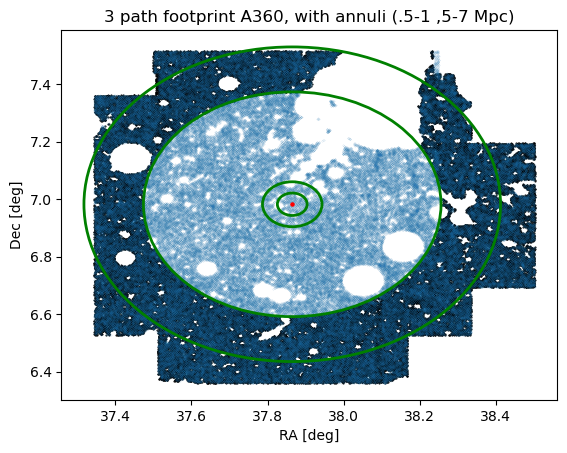

In [30]:
numberTrue, proportion = getArea()

In [35]:
def getArea(radiusSpecific, numberobjects):   
    ra_bcg = 37.86501659859067
    dec_bcg = 6.982204815599694
    
    # first have the baseline square 
    absolutemindec, absolutemaxdec, absoluteminra, absolutemaxra = findTheEdges(maskedcatalog)
    poly = hsp.HealSparseMap.make_empty(32, 32768, np.uint16)
    poly |= hsp.Polygon(ra=[absoluteminra, absoluteminra, absolutemaxra, absolutemaxra],
                        dec=[absolutemindec, absolutemaxdec, absolutemaxdec, absolutemindec],
                              value=1)
    
    desireddec, desiredra = searchSpecificLL(maskedcatalog, 37.4, 6.5)
    poly &= hsp.Polygon(ra=[absoluteminra, absoluteminra, desiredra, desiredra],
                        dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                              value=0)
    
    # remove the LR (in 2 parts) 
    # first remove the leftmost 
    desireddec, desiredra = searchSpecificLR(maskedcatalog, 38.2, 6.45)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                              value=0)
    
    # now remove the right part 
    desireddec, desiredra = searchSpecificLR(maskedcatalog, 38.4, 6.6)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                              value=0)
    
    # remove the UR (in 2 parts) 
    desireddec, desiredra = searchSpecificUR(maskedcatalog, 38.4, 7.3)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                              value=0)
    
    # second upper part 
    desireddec, desiredra = searchSpecificUR(maskedcatalog, 38.3, 7.45)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                              value=0)
    
    
    # remove UL (in 2 parts) 
    desireddec, desiredra = searchSpecificUL(maskedcatalog, 37.4, 7.4)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absoluteminra, absoluteminra],
                        dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                              value=0)
    
    ptRA = desiredra+0.005
    ptDEC = desireddec+0.02
    
    desireddecprime, desiredraprime = searchSpecificCUSTOM(maskedcatalog, ptRA, ptDEC, desireddec, desiredra)
    poly &= hsp.Polygon(ra=[desiredraprime, desiredraprime, desiredra, desiredra],
                        dec=[desireddec, desireddecprime, desireddecprime, desireddec],
                              value=0)

    # remove the inner annuli 
    poly &= hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=radiusSpecific, value=0)
    
    ra_rand, dec_rand = hsp.make_uniform_randoms_fast(poly, numberobjects)
    mask_rand = ~mask_hsp['full_mask'].get_values_pos(ra_rand, dec_rand, lonlat=True)

    numberTrue = np.sum(mask_rand)
    proportion = numberTrue/numberobjects
    
    fig, ax = plt.subplots()
    
    plt.scatter(ra_rand[mask_rand], dec_rand[mask_rand], marker='.', s=1, color='black', label='rng')
    plt.scatter(maskedcatalog['coord_ra'], maskedcatalog['coord_dec'], s=0.01, label='obj detected', alpha=0.5)
    plt.scatter(ra_bcg, dec_bcg, s=5, color='red')
    plt.xlabel("RA [deg]")
    plt.ylabel("Dec [deg]")
    plt.title("3 path footprint A360, with annuli (.5-1 ,5-7 Mpc)")
    
    circle2 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[1], color='green', fill=False, linewidth=2)
    circle3 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[2], color='green', fill=False, linewidth=2)
    circle4 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[-2], color='green', fill=False, linewidth=2)
    circle5 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[-1], color='green', fill=False, linewidth=2)
    
    ax.add_patch(circle3)
    ax.add_patch(circle2)
    ax.add_patch(circle4)
    ax.add_patch(circle5)

    return numberTrue, proportion

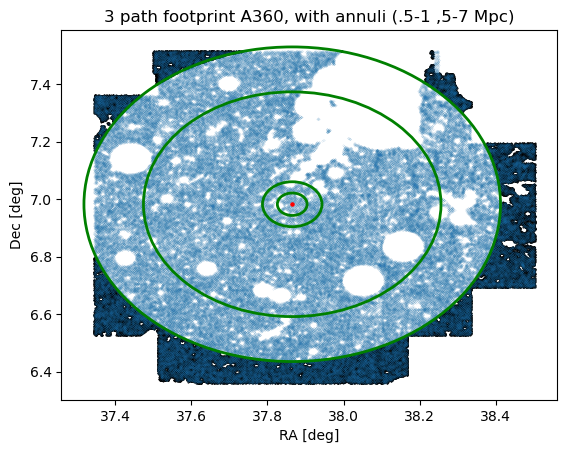

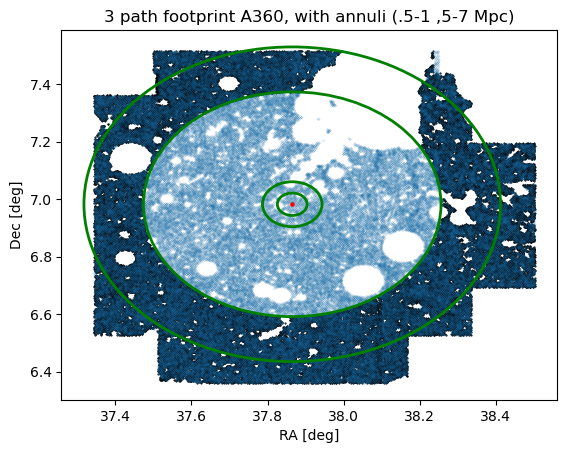

In [36]:
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
binsMpc = bins_mpc
binsdegrees = getBinsDegrees(binsMpc)

numberTrue1, proportion1 = getArea(binsdegrees[-1], int(1e5))
numberTrue2, proportion2 = getArea(binsdegrees[-2], int(1e5))

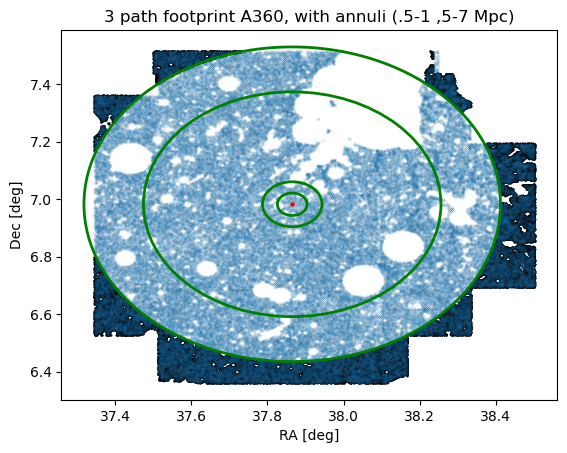

In [33]:
numberTrue, proportion = getArea2() 

In [ ]:
# got the area in two parts, to get just the annulus subtract the total () from 

In [55]:
# get the area for the inner annuli the same way as before... 

def getAreaInnerAnnuli(radiusIn, radiusOut, numberobjects, plot):
    poly = hsp.HealSparseMap.make_empty(32, 32768, np.uint16)

    # first have the outermost annulus 
    poly |= hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=radiusOut, value=1)
    
    # first have the baseline square 
    absolutemindec, absolutemaxdec, absoluteminra, absolutemaxra = findTheEdges(maskedcatalog)
    poly |= hsp.Polygon(ra=[absoluteminra, absoluteminra, absolutemaxra, absolutemaxra],
                        dec=[absolutemindec, absolutemaxdec, absolutemaxdec, absolutemindec],
                              value=1)
    
    desireddec, desiredra = searchSpecificLL(maskedcatalog, 37.4, 6.5)
    poly &= hsp.Polygon(ra=[absoluteminra, absoluteminra, desiredra, desiredra],
                        dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                              value=0)
    
    # remove the LR (in 2 parts) 
    # first remove the leftmost 
    desireddec, desiredra = searchSpecificLR(maskedcatalog, 38.2, 6.45)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                              value=0)
    
    # now remove the right part 
    desireddec, desiredra = searchSpecificLR(maskedcatalog, 38.4, 6.6)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[absolutemindec, desireddec, desireddec, absolutemindec],
                              value=0)
    
    # remove the UR (in 2 parts) 
    desireddec, desiredra = searchSpecificUR(maskedcatalog, 38.4, 7.3)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                              value=0)
    
    # second upper part 
    desireddec, desiredra = searchSpecificUR(maskedcatalog, 38.3, 7.45)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absolutemaxra, absolutemaxra],
                        dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                              value=0)
    
    
    # remove UL (in 2 parts) 
    desireddec, desiredra = searchSpecificUL(maskedcatalog, 37.4, 7.4)
    poly &= hsp.Polygon(ra=[desiredra, desiredra, absoluteminra, absoluteminra],
                        dec=[desireddec, absolutemaxdec, absolutemaxdec, desireddec],
                              value=0)
    
    ptRA = desiredra+0.005
    ptDEC = desireddec+0.02
    
    desireddecprime, desiredraprime = searchSpecificCUSTOM(maskedcatalog, ptRA, ptDEC, desireddec, desiredra)
    poly &= hsp.Polygon(ra=[desiredraprime, desiredraprime, desiredra, desiredra],
                        dec=[desireddec, desireddecprime, desireddecprime, desireddec],
                              value=0)

    # subtract annuli below radiusIn
    poly &= hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=radiusIn, value=0)
    
    ra_rand, dec_rand = hsp.make_uniform_randoms_fast(poly, numberobjects)
    mask_rand = ~mask_hsp['full_mask'].get_values_pos(ra_rand, dec_rand, lonlat=True)

    numberTrue = np.sum(mask_rand)
    proportion = numberTrue/numberobjects

    if plot: 
        fig, ax = plt.subplots()
        
        plt.scatter(ra_rand[mask_rand], dec_rand[mask_rand], marker='.', s=1, color='black', label='rng')
        plt.scatter(maskedcatalog['coord_ra'], maskedcatalog['coord_dec'], s=0.01, label='obj detected', alpha=0.5)
        plt.scatter(ra_bcg, dec_bcg, s=5, color='red')
        plt.xlabel("RA [deg]")
        plt.ylabel("Dec [deg]")
        plt.title("3 path footprint A360, with annuli (.5-1 ,5-7 Mpc)")
        
        circle2 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[1], color='green', fill=False, linewidth=2)
        circle3 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[2], color='green', fill=False, linewidth=2)
        circle4 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[-2], color='green', fill=False, linewidth=2)
        circle5 = plt.Circle((ra_bcg, dec_bcg), binsdegrees[-1], color='green', fill=False, linewidth=2)
        
        ax.add_patch(circle3)
        ax.add_patch(circle2)
        ax.add_patch(circle4)
        ax.add_patch(circle5)

    # what is the area of the annulus (in sq deg) 
    areaannulus = np.pi* (radiusOut**2) - np.pi * (radiusIn**2)
    
    # corresponding amount of area left, given the mask
    effectivearea = areaannulus * proportion

    arearemoved = areaannulus - effectivearea

    # convert to arcmin **2
    areaannulusarcmin = areaannulus * 3600
    effectiveareaarcmin = areaannulusarcmin * proportion
    arearemovedarcmin = areaannulusarcmin - effectiveareaarcmin

    return effectiveareaarcmin, proportion

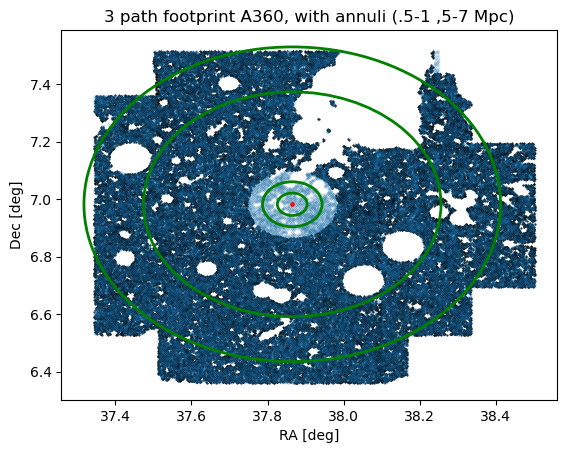

In [56]:
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
binsMpc = bins_mpc
binsdegrees = getBinsDegrees(binsMpc)

effectiveareaarcmin, proportion = getAreaInnerAnnuli(binsdegrees[3], binsdegrees[4], int(100000), True)

## First pass at the density 

In [146]:
def getUnmaskedArea(radiusIn, radiusOut, numberobjects, plot):
    # cluster coordinates
    ra_bcg = 37.86501659859067
    dec_bcg = 6.982204815599694

    circlemap = hsp.HealSparseMap.make_empty(32, 32768, np.uint16)

    # the outer radius 
    circlemap |= hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=radiusOut, value=1)
    # the inner radius 
    circlemap &= hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=radiusIn, value=0)

    ra_rand, dec_rand = hsp.make_uniform_randoms_fast(circlemap, numberobjects)

    #plt.scatter(ra_rand, dec_rand, marker='.', s=0.2)

    mask_rand = ~mask_hsp['full_mask'].get_values_pos(ra_rand, dec_rand, lonlat=True)

    if plot:
        plt.scatter(ra_rand, dec_rand, marker='.', s=0.2, color='c')
        plt.scatter(ra_rand[mask_rand], dec_rand[mask_rand], marker='.', s=0.2, color='black')

    numberTrue = np.sum(mask_rand)
    proportion = numberTrue/numberobjects

    # what is the area of the annulus (in sq deg) 
    areaannulus = np.pi* (radiusOut**2) - np.pi * (radiusIn**2)
    
    # corresponding amount of area left, given the mask
    effectivearea = areaannulus * proportion

    arearemoved = areaannulus - effectivearea

    # convert to arcmin **2
    areaannulusarcmin = areaannulus * 3600
    effectiveareaarcmin = areaannulusarcmin * proportion
    arearemovedarcmin = areaannulusarcmin - effectiveareaarcmin

    return effectiveareaarcmin, proportion

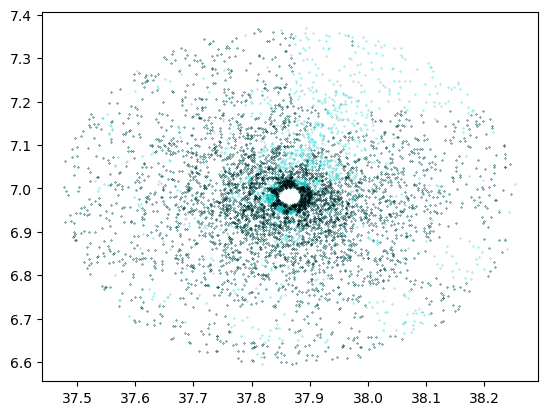

In [147]:
# use standarized bins 
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
binsdegrees = getBinsDegrees(bins_mpc)

areas = []
proportions = []
for x in range(len(binsdegrees[:-2])):
    if x == 0: 
        effectiveareaarcmin, proportion = getUnmaskedArea(binsdegrees[x], binsdegrees[x+1], int(1000), True)
        areas.append(effectiveareaarcmin)
        proportions.append(proportion)
    else: 
        effectiveareaarcmin, proportion = getUnmaskedArea(binsdegrees[x], binsdegrees[x+1], int(1000), True)
        areas.append(effectiveareaarcmin)
        proportions.append(proportion)


Text(0.5, 0, 'radius (Mpc)')

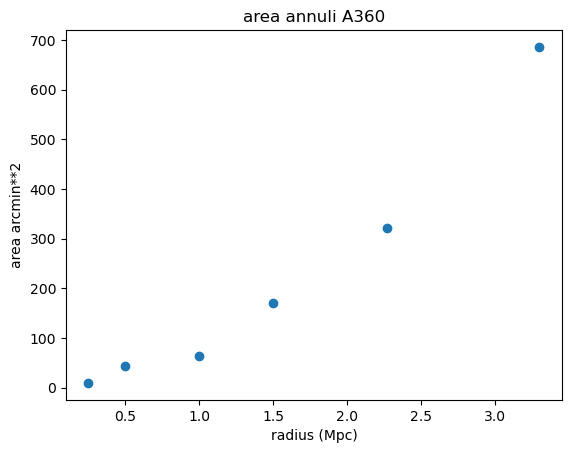

In [148]:
plt.scatter(binsMpc[:-2], areas)
plt.title('area annuli A360')
plt.ylabel('area arcmin**2')
plt.xlabel('radius (Mpc)')

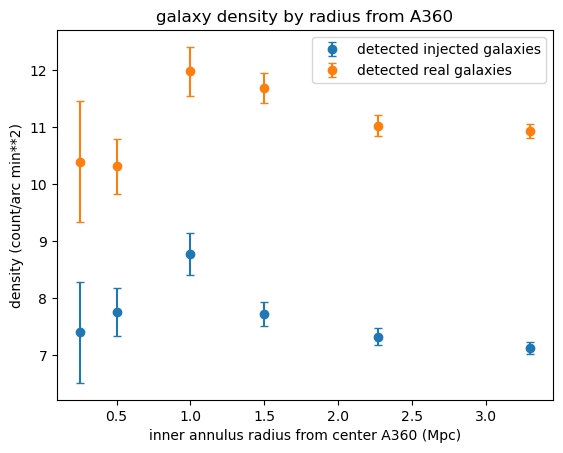

In [149]:
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
binsMpc = bins_mpc
binsdegrees = getBinsDegrees(binsMpc)

entirecounts, bins = np.histogram(allWL['sep'], bins = binsdegrees)
realcounts, bins = np.histogram(nonInjectedWL['sep'], bins = binsdegrees)
injectedcounts, bins = np.histogram(injectedWL['sep'], bins = binsdegrees)

originalentirecounts, bins = np.histogram(originalAllWL['sep'], bins = binsdegrees)
originalrealcounts, bins = np.histogram(originalNonInjectedWL['sep'], bins = binsdegrees)
originalinjectedcounts, bins = np.histogram(originalInjectedWL['sep'], bins = binsdegrees)

# plot the distribution after all the cuts (right) 
entirecounts, bins = np.histogram(allWL['sep'], bins = binsdegrees)
realcounts, bins = np.histogram(nonInjectedWL['sep'], bins = binsdegrees)
injectedcounts, bins = np.histogram(injectedWL['sep'], bins = binsdegrees)

proportionAll = entirecounts/ originalentirecounts
proportionReal = realcounts/originalrealcounts
proportionInjected = injectedcounts/originalinjectedcounts

# get the unceriatinities 
uncert0 = []
uncert1 = []
for x in range(len(proportions)): 
    uc0 = getDensityError(proportionReal[x], realcounts[x], areas[x], int(1e5))
    uc1 = getDensityError(proportionInjected[x], injectedcounts[x], areas[x], int(1e5))
    uncert0.append(uc0)
    uncert1.append(uc1)

plt.errorbar(binsMpc[:-2], injectedcounts[:-1]/areas, yerr=uncert1, label='detected injected galaxies', fmt='o', capsize=3)
plt.errorbar(binsMpc[:-2], realcounts[:-1]/areas, yerr = uncert0, label='detected real galaxies', fmt='o', capsize=3)
plt.xlabel('inner annulus radius from center A360 (Mpc)')
plt.ylabel('density (count/arc min**2)')
plt.title('galaxy density by radius from A360')
plt.legend()

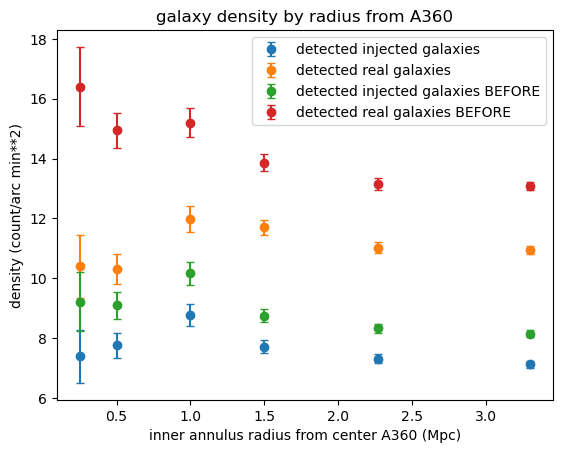

In [150]:

errReal = getDensityErrorPoissonCountOnly(originalrealcounts[:-1], areas)
errInj = getDensityErrorPoissonCountOnly(originalinjectedcounts[:-1], areas)

plt.errorbar(binsMpc[:-2], injectedcounts[:-1]/areas, yerr=uncert1, label='detected injected galaxies', fmt='o', capsize=3)
plt.errorbar(binsMpc[:-2], realcounts[:-1]/areas, yerr = uncert0, label='detected real galaxies', fmt='o', capsize=3)

plt.errorbar(binsMpc[:-2], originalinjectedcounts[:-1]/areas, yerr=errInj, label='detected injected galaxies BEFORE', fmt='o', capsize=3)
plt.errorbar(binsMpc[:-2], originalrealcounts[:-1]/areas, yerr = errReal, label='detected real galaxies BEFORE', fmt='o', capsize=3)
plt.xlabel('inner annulus radius from center A360 (Mpc)')
plt.ylabel('density (count/arc min**2)')
plt.title('galaxy density by radius from A360')
plt.legend()

### Compare to the intial sample 

In [196]:
def plotDensitySamples(maskBoolean, extendednessBoolean, magBoolean, areas):
    sepCatalog = Table.read("SSIsepCatalog.fits")

    if maskBoolean: 
        sepCatalog = Table.read("SSIMaskedCat.fits")
        print("after mask cut", len(sepCatalog))

    if extendednessBoolean: 
        allExtendedObjMask = sepCatalog['refExtendedness'] >= 0.5
        sepCatalog = sepCatalog[allExtendedObjMask]
        print("after extendedness cuts", len(sepCatalog))

    if magBoolean: 
        sepCatalog = verifyWLGalaxyCatalog(sepCatalog, True)
        print("after mag cut", len(sepCatalog))

    # split the samples up 
    injectedmaskcolumn = sepCatalog["ref_r_comp1_source_type"]
    injectedmaskcolumnmask = injectedmaskcolumn.mask 
    onlyNonInjectedObjects = sepCatalog[injectedmaskcolumnmask]
    inverseinjectedmaskcolumnmask = ~injectedmaskcolumnmask
    onlyInjectedObjects = sepCatalog[inverseinjectedmaskcolumnmask]
    
    ## get the counts in each bin 

    allObjectsCounts, bins = np.histogram(sepCatalog['sep'], bins = binsdegrees)
    allRealObjectsCounts, bins = np.histogram(onlyNonInjectedObjects['sep'], bins = binsdegrees)
    allInjObjectsCounts, bins = np.histogram(onlyInjectedObjects['sep'], bins = binsdegrees)
    
    ## get the uncertinaity in each bin 
    uncertAll = getDensityErrorPoissonCountOnly(allObjectsCounts[:-1], areas)
    uncertReal = getDensityErrorPoissonCountOnly(allRealObjectsCounts[:-1], areas)
    uncertInj = getDensityErrorPoissonCountOnly(allInjObjectsCounts[:-1], areas)

    densityAll = allObjectsCounts[:-1]/areas
    densityReal = allRealObjectsCounts[:-1]/areas
    densityInj = allInjObjectsCounts[:-1]/areas
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    ax.errorbar(binsMpc[:-2], allObjectsCounts[:-1]/areas, yerr=uncertAll, fmt='o', capsize=3, label=f'real + inj')
    ax.errorbar(binsMpc[:-2], allRealObjectsCounts[:-1]/areas, yerr=uncertReal, fmt='o', capsize=3, label=f'real only')
    ax.errorbar(binsMpc[:-2], allInjObjectsCounts[:-1]/areas, yerr=uncertInj, fmt='o', capsize=3, label=f'inj only')
    
    plt.title(f'density of items in annular bins by sample type; mask {maskBoolean}, ext {extendednessBoolean}, mag {magBoolean}')
    plt.ylabel('density (count/arc min**2)')
    plt.xlabel('sep from cluster center (Mpc)')
    plt.legend()

    return densityAll, densityReal, densityInj, uncertAll, uncertReal, uncertInj

# obj in catalog: 166470
# obj in the WL mag range: 69862
# extended obj in WL mag range: 69862
extendedness removes: 0

# obj in catalog: 58154
# obj in the WL mag range: 26138
# extended obj in WL mag range: 26138
extendedness removes: 0

# obj in catalog: 108316
# obj in the WL mag range: 43724
# extended obj in WL mag range: 43724
extendedness removes: 0



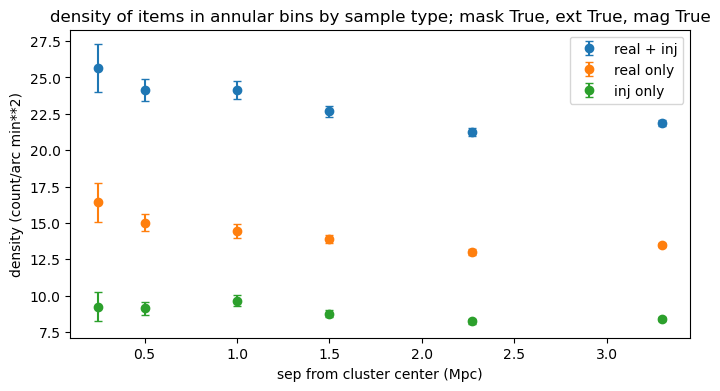

In [202]:
densityAll, densityReal, densityInj, uncertAll, uncertReal, uncertInj = plotDensitySamples(True, True, True, areas)

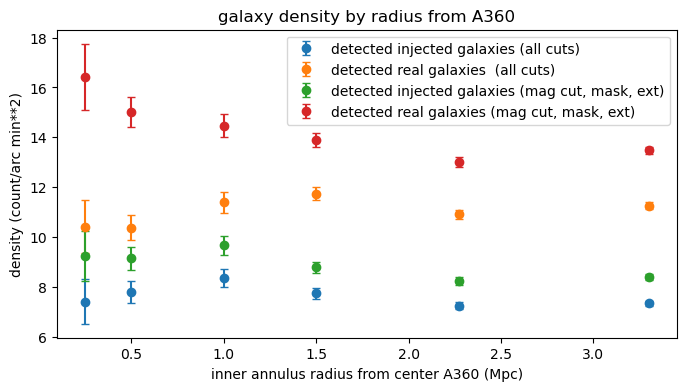

In [165]:
errReal = getDensityErrorPoissonCountOnly(originalrealcounts[:-1], areas)
errInj = getDensityErrorPoissonCountOnly(originalinjectedcounts[:-1], areas)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))


plt.errorbar(binsMpc[:-2], injectedcounts[:-1]/areas, yerr=uncert1, label='detected injected galaxies (all cuts)', fmt='o', capsize=3)
plt.errorbar(binsMpc[:-2], realcounts[:-1]/areas, yerr = uncert0, label='detected real galaxies  (all cuts)', fmt='o', capsize=3)

plt.errorbar(binsMpc[:-2], originalinjectedcounts[:-1]/areas, yerr=errInj, label='detected injected galaxies (mag cut, mask, ext)', fmt='o', capsize=3)
plt.errorbar(binsMpc[:-2], originalrealcounts[:-1]/areas, yerr = errReal, label='detected real galaxies (mag cut, mask, ext)', fmt='o', capsize=3)
plt.xlabel('inner annulus radius from center A360 (Mpc)')
plt.ylabel('density (count/arc min**2)')
plt.title('galaxy density by radius from A360')
plt.legend()

In [ ]:
# combine the plots 